#### packages and functions

In [2]:
from pathlib import Path
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import time
import os
from scipy import signal
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit
from scipy.special import erf
import scipy.io
import colorsys
from scipy import signal
import math
from scipy.stats import norm
import pickle
import os
import pandas as pd

import ipyparams
from e6py import E6math
from e6py import Photontimer
from e6py import smart_gaussian2d_fit


ModuleNotFoundError: No module named 'ipyparams'

In [2]:
from scipy.interpolate import interp1d

def uniquebin(x, y):
    '''
    x: x values
    y: y values
    gets unique values of x and y arrays and computes 
    mean and standard deviation of y values corresponding to each x value
    '''
    # select unique values of x and y arrays
    xbin = np.unique(np.array(x).astype('float'))
    # generate similar dimension array of zeros
    ybin = xbin * 0;
    ybinerr = xbin * 0;
    ybinmean_err = xbin * 0;
    for i in range(0, len(xbin)):
        # store y values corresponding to current x value
        ytemplist = y[x == xbin[i]]
        # compute mean 
        ybin[i] = np.nanmean(ytemplist)
        # compute standard deviation
        ybinerr[i] = np.nanstd(ytemplist)
        # compute standard error of the mean
        ybinmean_err[i] = ybinerr[i]/np.sqrt(np.sum(x == xbin[i]))
    return xbin, ybin, ybinerr,ybinmean_err


def rabi_oscillation_t(tau,fR,phi,A=1,offset=0):
    # compute Rabi oscillation
    return A*np.cos(2*np.pi*tau*fR+phi)+offset


def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    '''
    tau: time
    fR: Rabi frequency
    delta: detuning
    f: frequency of the qubit
    f0: frequency of the drive
    compute effective Rabi oscillation'''
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

def rabi_oscillation_decoherence(tau=0, fR=3e3, gamma=0, Amp=1, offset=0):
    '''
    tau: time
    fR: Rabi frequency
    gamma: decoherence rate
    Amp: amplitude
    offset: offset
    compute Rabi oscillation with decoherence'''

    w=np.exp(-0.5*gamma*tau)*(np.cos(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau)+(gamma/2/np.sqrt(fR**2-(gamma/2)**2))*np.sin(2*np.pi*np.sqrt(fR**2-(gamma/2)**2)*tau))
    return Amp*(1-w)/2+offset

def butter_lowpass_filter(data, cutoff, order):
    '''
    data: input data
    cutoff: cutoff frequency
    order: order of the filter
    returns filtered data using Butterworth filter'''
    b, a = signal.butter(order, cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def exp_fun_2(t,alpha,A=1,B=0):
    # fits exponential
    return A*np.exp(-2*alpha*t)+B


def exp_fun(t,gamma,A=1,B=0):
    # another exponential fit
    return A*np.exp(-gamma*t)+B

# create an interpolated function (cicero control voltage to power conversion curve?)
x_int=np.array([0,0.7 ,0.8, 0.9, 1   ,1.1,  1.2, 1.3,  1.4,  1.5, 1.6,   1.7  ,1.8  ,2.0  ,2.1  ,2.2  ,2.5  ,3  ,3.5, 4  ,4.5,5  ,5.5,6  ,6.5,7.5,8.5,10])
y_int=np.array([0,0.99,7.18,20.7,41.3,65.3, 90.5,115.4,138.1,159.0,178.5,195.6,210.3,236.7,248.4,258.7,283.8,314,335, 349,361,370,376,383,388,397,402,408])
y_int=y_int/np.max(y_int)
power_curve= interp1d(x_int,y_int,kind='slinear')

def ControlV_Power(x,maximum_power=1):
    # control voltage to power conversion
    return maximum_power*power_curve(x)

def double_lorentzian_fit(f, A, B, kappa, gamma, f0):
    # fit lorentzian 1
    return A/(1+(2*(f-f0)/kappa)**2) + B/(1+(2*(f-f0)/gamma)**2)

def lorentzian_fit(f, A, kappa, f0):
    # fit lorentzian 2
    return A/(1+(2*(f-f0)/kappa)**2)

# Cavity Fluorescence 

## Load data

### User input section

In [459]:
########################### User input section ############################
# run info
currentnotebook_name = ipyparams.notebook_name
run_name = currentnotebook_name[:-6]
run_name = 'run0'

#Boolean input
override_num_shots = False
reset_hard = False #only set this to true if you want to reload from raw data


#number input, we will probably want this to be a dashboard
num_shots_manual = 200 
num_frames = 3
outer_zoom_factor = 5
point_name_inner='Pzt_cav'
point_list_outer = np.array([0.5])
point_list_inner = np.linspace(-0.6,1.2,7)
tweezer_freq_list = 88 + 0.8*0 + 0.8*np.arange(40) # tweezer frequencies. how to best express this in NL?
tweezer_indices = [14,26] # for 2 atom runs

atom_site = []
for i in range(num_frames):
    atom_site.append(np.arange(len(tweezer_freq_list)))

#################################################################################
num_points_inner = len(point_list_inner)
num_points_outer = len(point_list_outer)
if num_points_outer == 1:
    point_list = np.array(point_list_inner)
else:
    # create outer product of point_list_outer and point_list_inner
    # multiply by a zoom factor
    # add 1D array of point_list_inner and just ones
    # flatten the array
    point_list = (outer_zoom_factor
                  * np.outer(point_list_outer,np.ones(len(point_list_inner))) 
                    + np.outer(np.ones(len(point_list_outer)), point_list_inner)).flatten()
    plt.plot(point_list)
num_points = len(point_list)


In [460]:
# set paths, we should also have a dashboard for this
datastream_name='High NA Imaging'
working_path = Path.cwd().parent
data_path = working_path/'data'/run_name/datastream_name
file_prefix='jkam_capture'
path, dirs, files = next(os.walk( data_path ))

### Check for file number mismatch gitch

In [461]:
#run this the first time to spot any file offset glitches
datastream_name='High NA Imaging'
working_path = Path.cwd().parent
data_path = working_path/'data'/run_name/datastream_name
file_prefix='jkam_capture'
path, dirs, files = next(os.walk( data_path ))

# use jkam as the reference, as jkam typically doesn't miss
num_shots_jkam = len(files)
num_shots = num_shots_jkam
num_loops = num_shots//num_points
num_tweezers = len(tweezer_freq_list)
num_points = len(point_list)
# compute the number of total loops
num_loops = num_shots//num_points + bool(num_shots%num_points)
print(f'num_points={num_points}, num_loops={num_loops}')
print(f'num_shots={num_shots}')

if override_num_shots:
    num_shots = num_shots_manual

# path, dirs, files = next(os.walk(data_path))
# num_shots_fpga = len(files)
# # num_shots = num_shots_fpga
# if override_num_shots:
#     num_shots = num_shots_manual
jkam_creation_time_array =  np.zeros(num_shots)

for shot_num in range(num_shots):
    # get creation times of files   
    file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
    jkam_creation_time_array[shot_num] = os.path.getctime(data_path/file_name)
    if shot_num%1000 == 0:
        print(shot_num)

# compute time gaps between shots
avg_time_gap = (jkam_creation_time_array[-1]-jkam_creation_time_array[0])/(num_shots-1)
# fpga_creation_time_gap = fpga_creation_time_array[1:]-fpga_creation_time_array[:-1]

# read in SPCM data and opal kelly data
datastream_name='PhotonTimer_Silver'
working_path = Path.cwd().parent
data_path_fpga = working_path/'data'/run_name/datastream_name
fpga_file_prefix='PTPhotonTimer_Silver'
fpga_creation_time_array =  np.zeros(num_shots)

opal_path, opal_dirs, opal_files = next(os.walk( data_path_fpga ))
num_shots_fpga=len(opal_files)

for shot_num in range(num_shots):
    if shot_num < num_shots_fpga:
        file_name = fpga_file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
        # get creation times of opal kelly files
        fpga_creation_time_array[shot_num] = os.path.getctime(data_path_fpga/file_name)
        if shot_num%1000 ==0:
            print(shot_num)

#Check data matching
# boolean array initialized to false, same length as jkam creation time
mask_valid_data=np.zeros(len(jkam_creation_time_array))>1
# array initialized to -1, same length as jkam creation time
jkam_fpga_matchlist=np.zeros(len(jkam_creation_time_array),dtype='int')-1
# array of fpga indices
fpga_index_list=np.arange(len(fpga_creation_time_array))

for shot_num in range(num_shots):
    # jkam reference time
    time_temp=jkam_creation_time_array[shot_num]
    space_correct=True
    # does the previous and current shots creation time deviate from average time gap by more than 20%?
    if (shot_num > 0) & (np.abs(time_temp 
                              - jkam_creation_time_array[shot_num-1] 
                              - avg_time_gap)>0.2*avg_time_gap): 
          space_correct=False

    if (shot_num < (num_shots-1)):
        if (np.abs(- time_temp
                   + jkam_creation_time_array[shot_num+1] 
                   - avg_time_gap) > 0.2*avg_time_gap): 
             space_correct=False
    
    # is the minimum absolute difference between the current shot creation time 
    #and FPGA creation time less than 20% of average time gap?
    if ((np.min(np.abs(fpga_creation_time_array - time_temp)) <= 0.2*avg_time_gap)) & space_correct:
        # set mask index to true
        mask_valid_data[shot_num]=True
        # store the index of the FPGA creation time, essentially stores FPGA shots that match JKAM shots
        jkam_fpga_matchlist[shot_num]=fpga_index_list[np.argmin(np.abs(fpga_creation_time_array-time_temp))]
    else:
        print(f'error at {shot_num:d}')
    if shot_num%1000 ==0:
            print(shot_num)

num_points=7, num_loops=57
num_shots=396
0
0
0
error at 11
error at 12
error at 13


In [462]:
# # use this section to manually locate the file offset glitches and update them
# plt.figure()
# plt.title("photontimer file delay (positive for miss trigger on photontimer)")
# plt.plot((fpga_creation_time_array-jkam_creation_time_array)/avg_time_gap)
# # plt.ylim([-2,2])
# # plt.xlim([835,838])

In [463]:
# plt.plot(fpga_creation_time_array[834:839])
# plt.plot(jkam_creation_time_array[834:839])

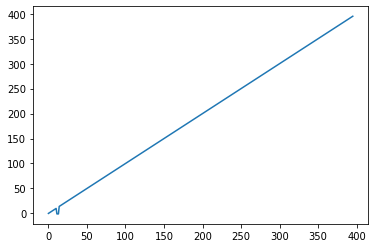

In [464]:
# show where errors occurred
plt.plot(jkam_fpga_matchlist)

### Load from red opal kelly

In [465]:
plot_fig = True
start = time.time()

# datastream_name='PhotonTimer'
# working_path = Path.cwd().parent
# data_path_fpga = working_path/'data'/run_name/datastream_name
# file_prefix='PTPhotonTimer'

threshold=2
box=1

frame_num = 0
unit_time_PT = 1/700 #us

# path, dirs, files = next(os.walk(data_path_fpga))
# num_shot_start = 0
# num_shots_opal = len(files)
# num_shots = num_shots_opal
# num_shots = num_shots_opal


# if override_num_shots:
#     num_shots = num_shots_manual
    
try:
    shot_num_loaded = len(np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True))
except FileNotFoundError:
    shot_num_loaded = 0
    
PT_cavity_photoncount_array=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array[:] = np.NaN
PT_cavity_photoncount_array_raw=np.zeros((num_shots, num_frames))
PT_cavity_photoncount_array_raw[:] = np.NaN
PT_cavity_timestamp_array_raw = np.empty(num_shots, dtype=object)
#################################################################
if reset_hard:
    print(f'loading {num_shots} shots from PT raw data')

    for shot_num in range(num_shots):
        if shot_num%100 == 0:
            print(f'shot{shot_num} done')
        if mask_valid_data[shot_num]:   
            file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
            with open(data_path_fpga/file_name, 'rb') as f:

                bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                # events, events_malformed = te.parse(bin_data) # numba version
    #             print(len(bin_data))
                events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                # print(events[4])
            timestamps = np.sort(events[4])
            PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
        else:
            PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
    with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
         pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
#########################################################################################
else:
    print(f'loading {shot_num_loaded} shots from PT pickle file')
    try:
        PT_cavity_timestamp_array_raw[:shot_num_loaded] = np.load(f'{run_name}_FPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')
    except:
        print('first time run')
    
    if (num_shots > shot_num_loaded):
        print(f'loading {shot_num_loaded} to {num_shots} shots from raw data')
        for shot_num in range(shot_num_loaded, num_shots):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
                
            if mask_valid_data[shot_num]:
                file_name = fpga_file_prefix+'_'+str(jkam_fpga_matchlist[shot_num]).zfill(5)+'.bin'
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
                timestamps = np.sort(events[4])
                PT_cavity_timestamp_array_raw[shot_num]  = unit_time_PT * timestamps
            else:
                PT_cavity_timestamp_array_raw[shot_num] = np.array([0])
            
        with open(f'{run_name}_FPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(PT_cavity_timestamp_array_raw, f1)
          
    print('done')
    
    

print(f"time elapsed {time.time()-start} s")




loading 380 shots from PT pickle file
done
loading 380 to 396 shots from raw data


done
time elapsed 1.4447221755981445 s


### Load from silver opal kelly

In [466]:
plot_fig = True

load_silver = False

override_num_shot_silvers= override_num_shots

num_shot_silvers_manual=num_shots_manual
# num_shot_silvers_manual = 600

file_read_every=50

if load_silver:

    start = time.time()

    datastream_name='PhotonTimer_Silver'
    working_path = Path.cwd().parent
    data_path_fpga = working_path/'data'/run_name/datastream_name
    file_prefix='PTPhotonTimer_Silver'

    # axialPD_avg_array = np.zeros(num_shot_silvers)
    # axialPD_avg_array[:] = np.NaN
    # axialPD_sigma_array = np.zeros(num_shot_silvers)
    # axialPD_sigma_array[:] = np.NaN
    # step_start = 15000
    # step_end = 25000
    threshold=2
    box=1
    cumulative_file_offset = 0
    frame_num = 0
    unit_time_PT = 1/700 #us


    path, dirs, files = next(os.walk(data_path_fpga))
    # num_shot_silvers = 600
    num_shot_silver_start = 0
    num_shot_silvers_fpga = len(files)
    num_shot_silvers = num_shot_silvers_fpga
    # num_shot_silvers = num_shot_silvers_fpga
    if override_num_shot_silvers:
        num_shot_silvers = num_shot_silvers_manual

    try:
        shot_num_loaded = len(np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True))
    except FileNotFoundError:
        shot_num_loaded = 0

    #################################################################
    if num_shot_silvers != shot_num_loaded or reset_hard:

        print(f'loading {num_shot_silvers} shots from PT raw data')
        PT_cavity_photoncount_array=np.zeros((num_shot_silvers, num_frames))
        PT_cavity_photoncount_array[:] = np.NaN
        PT_cavity_photoncount_array_raw=np.zeros((num_shot_silvers, num_frames))
        PT_cavity_photoncount_array[:] = np.NaN
    #     PT_cavity_timestamp_array = np.empty((num_shot_silvers, num_frames), dtype=object)
        Silver_PT_cavity_timestamp_array_raw = np.empty(num_shot_silvers, dtype=object)

        for shot_num in range(num_shot_silvers):
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')

            file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.bin'
            if (shot_num % file_read_every)==0:
                with open(data_path_fpga/file_name, 'rb') as f:

                    bin_data = np.unpackbits(np.fromfile(f, dtype=np.uint8))
                    # events, events_malformed = te.parse(bin_data) # numba version
        #             print(len(bin_data))
                    events, events_malformed = Photontimer.process_timer_py(bin_data) # pure python version
                    # print(events[4])
            timestamps = np.sort(events[4])
            Silver_PT_cavity_timestamp_array_raw[shot_num-cumulative_file_offset]  = unit_time_PT * timestamps

        with open(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl','wb') as f1:
             pickle.dump(Silver_PT_cavity_timestamp_array_raw, f1)

        print('done')
    #########################################################################################
    else:
        print(f'loading {shot_num_loaded} shots from Silver PT pickle file')
        Silver_PT_cavity_timestamp_array_raw = np.load(f'{run_name}_SilverFPGA_timestamp_array_raw.pkl', allow_pickle=True)
        print('done')


    print(f"time elapsed {time.time()-start} s")

In [467]:
### Haven't updated the file offset correction on the silver opal #TO DO

if load_silver:

    t_prep = 100
    f_sweep_start = -2
    t_sweep = 2e3
    f_sweep_end = 2
    f0_array = np.zeros(num_shot_silvers)
    f0_array[:] = np.NaN
    for shot_num in range(num_shot_silvers):

        try:
            pfs_freq = Silver_PT_cavity_timestamp_array_raw[shot_num] - t_prep
            pfs_freq = f_sweep_start+(pfs_freq/t_sweep)*(f_sweep_end-f_sweep_start)
            bins=20
            bin_time = t_sweep/bins
            n, bins = np.histogram(pfs_freq, bins=bins)

            x_sample = np.arange(f_sweep_start, f_sweep_end, 0.01)
            popt, pcov = curve_fit(E6math.CauchyNoOffset, (bins[1:]+bins[:-1])/2,n/bin_time, p0=(1,1000,0))
        #     print(f'shot#={shot_num}, f0={popt[2]:5.3f}MHz')
            f0_array[shot_num] = popt[2]
        except:
            f0_array[shot_num] = np.nan
        
        if shot_num==0:
            plt.plot((bins[1:]+bins[:-1])/2,n,'o-')
            plt.xlabel('probe_freq_offset_MHz',fontsize=12)
            plt.ylabel('photon counts',fontsize=12)
#     plt.figure(figsize=(10,5))
#     bins=50
#     plt.hist(f0_array, alpha=0.5, color='b', bins=bins)
#     plt.ylabel('occurence')
#     plt.xlabel('delta_PC_zero')

    f0_whole_run = np.nanmean(f0_array)
    print(f'averaged f0 = {f0_whole_run}')

    filtered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.1, order=2)
    slowfiltered_f0_array = butter_lowpass_filter(f0_array, cutoff=0.02, order=2)

    plt.figure(figsize=(10,5))
    bins=50
    plt.plot(np.arange(num_shot_silvers),f0_array)
    plt.plot(np.arange(num_shot_silvers),filtered_f0_array)
    plt.plot(np.arange(num_shot_silvers),slowfiltered_f0_array)
    plt.xlabel('shot#')
    plt.ylabel('delta_PC_zero')
#     plt.ylim(-5,5)
#     plt.xlim(-5,5)

In [468]:
# plt.plot((bins[1:]+bins[:-1])/2,n/bin_time)

In [469]:
# plt.plot((bins[1:]+bins[:-1])/2,n/bin_time)

In [470]:
# plt.plot((bins[1:]+bins[:-1])/2,n/bin_time)

### ROI user input and load JKAM data

In [471]:
roi_width = 12
roi_height = 12
roi_area = roi_width * roi_width

def roi_center(tweezer_freq):
    center_x = round(2 * (0.01 * (tweezer_freq - 108)**2+ 26.8 * (tweezer_freq - 100) + 417)) / 2
    center_y = round(2 * (-0.4 * (tweezer_freq - 100) + 28)) / 2
    return [center_x, center_y]

def roi_slice_func(tweezer_freq):
    center_x = roi_center(tweezer_freq)[0]
    center_y = roi_center(tweezer_freq)[1]
    return tuple((slice(round(center_y - roi_height / 2), round(center_y + roi_height / 2), 1), \
                  slice(round(center_x - roi_width / 2), round(center_x + roi_width / 2), 1)))

start = time.time()

quiet = False
plot_true = False
datastream_name='High NA Imaging'
working_path = Path.cwd().parent
data_path = working_path/'data'/run_name/datastream_name
file_prefix='jkam_capture'

path, dirs, files = next(os.walk(data_path))
# num_shots = 600
num_shot_start = 0
num_shots_jkam = num_shots


# cells array for raw images
# image_array = [[[None for _ in range(num_tweezers)] for _ in range(num_frames)] for _ in range(num_shots)]

# num_shots = num_shots_fpga
if override_num_shots:
    num_shots = num_shots_manual
try:
    shot_num_loaded = len(np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True))
except FileNotFoundError:
    shot_num_loaded = 0
    

if num_shots != shot_num_loaded or reset_hard:
    print(f'loading {num_shots} shots from raw data')
    counts_array = np.empty([num_shots, num_frames, num_tweezers])
    frames_array = np.zeros([num_frames,80,1100])
    image_array = [[[None for _ in range(num_tweezers)] for _ in range(num_frames)] for _ in range(num_shots)]
    for shot_num in range(num_shot_start, num_shot_start+num_shots):
        if quiet == False and shot_num%1000 == 0: 
            print(f'shot_num={shot_num}')

        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        hf = h5py.File(data_path/file_name, 'r')
        point = shot_num % num_points
        for frame_num in range(num_frames):
            photo = np.array(hf.get('frame-'+str(frame_num+2).zfill(2)))
            tweezer_freq_counter = 0     
            for tweezer_freq in tweezer_freq_list:
                image_array[shot_num-num_shot_start][frame_num][tweezer_freq_counter]= np.array(photo[roi_slice_func(tweezer_freq)],dtype='int32')
                counts_array[shot_num-num_shot_start, frame_num, tweezer_freq_counter] = np.sum(photo[roi_slice_func(tweezer_freq)])
                tweezer_freq_counter += 1

            frames_array[frame_num] += photo

            if plot_true == False: 
                if frame_num == 5:
                    vmin = 105
                    vmax = 140

                    fig,ax = plt.subplots(1, 1,figsize=(10, 10) )
                    ax.imshow(photo, norm = colors.Normalize(vmin=vmin,vmax=vmax), cmap='hot', interpolation='nearest')
                    for tweezer_freq in tweezer_freq_list:
                        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
                        ax.add_patch(rect1)
                    plt.show()
                    print(counts_array[shot_num-num_shot_start, frame_num])

        hf.close
    frames_array = frames_array/num_shots*num_points
    
    with open(f'{run_name}_jkam_counts_array.pkl','wb') as f1:
         pickle.dump(counts_array, f1)
    with open(f'{run_name}_jkam_frames_array.pkl','wb') as f2:
         pickle.dump(frames_array, f2)
    with open(f'{run_name}_jkam_images_array.pkl','wb') as f3:
         pickle.dump(image_array, f3)
            
    print('done')
else:
    print(f'loading { shot_num_loaded} shots from pickle file')
    counts_array = np.load(f'{run_name}_jkam_counts_array.pkl', allow_pickle=True)
    frames_array = np.load(f'{run_name}_jkam_frames_array.pkl', allow_pickle=True)
    image_array = np.load(f'{run_name}_jkam_images_array.pkl', allow_pickle=True)
    print('done')

print(f"time elapsed {time.time()-start} s")

loading 396 shots from raw data
shot_num=0


done
time elapsed 59.95265603065491 s


## Select data

##### User input section

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.]


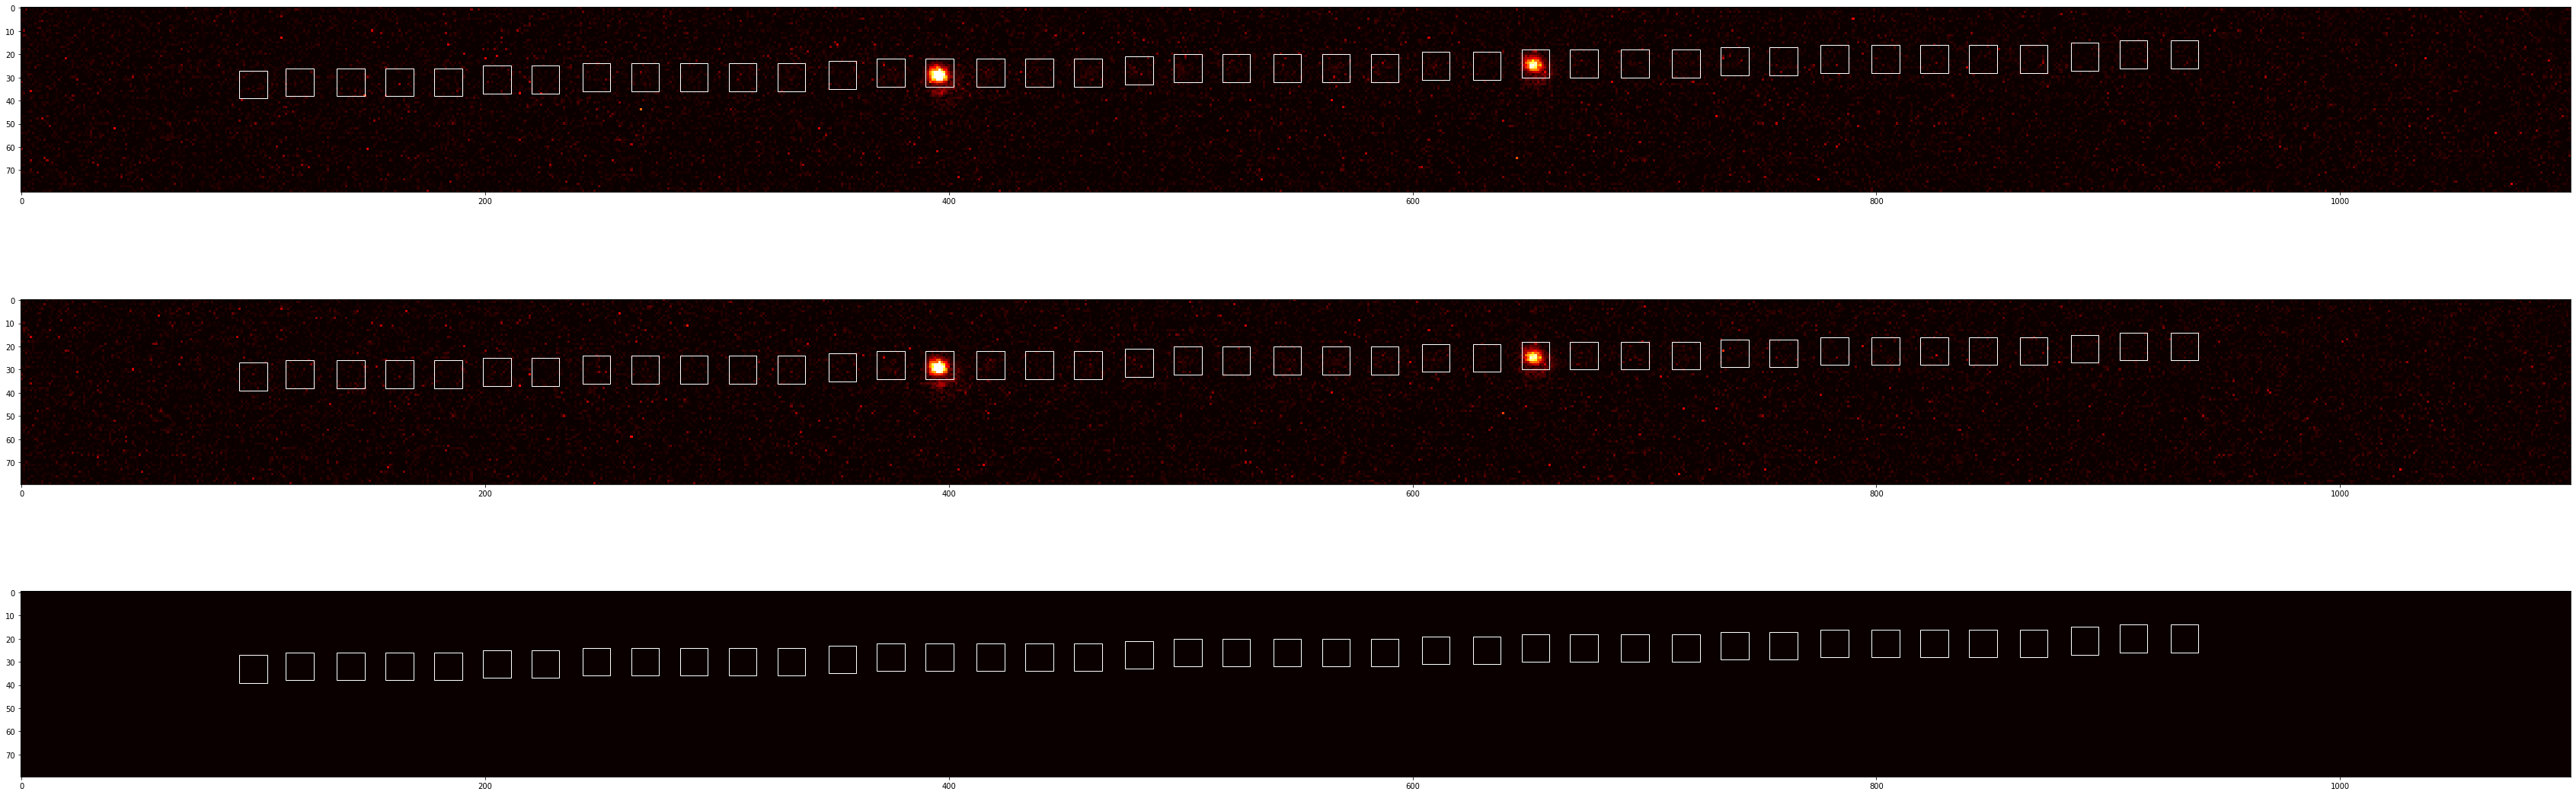

In [472]:
########################### User input section ############################

#Boolean input
###############################################
post_select_true = False
realtime_frequency_zeroing = True
quiet = False
probe_trim = False
odt_freq_center_override = True
plot_many_figures = True
plot_sigma_of_mean = False
###############################################
if plot_sigma_of_mean:
    divider = np.sqrt(num_loops)
else:
    divider = 1


#number input
###############################################
num_start = 0 # This has to be an integer times num_points
num_end = num_shots
num_shots_sliced = num_end - num_start
# num_end = 5000
t_probe_trim = 50 #us #only applied when probe_trim = True
dark_count_threshold=-1
odt_freq_center = -2 #only applied when odt_freq_center_override = True
cav_dark_threshold = 1.5

num_frames_cav_per_twz = 1
t_pre = 201 #us
t_cav_frame = 20*3.22e3 #44.4e3 #us
t_cav_expo = t_cav_frame #44.4e3 #us
t_gap = 270.065
###############################################

# num_frames_cav = tweezer_num * num_frames_cav_per_twz
num_frames_cav = 1 * num_frames_cav_per_twz
t_cav_start=np.array([t_pre+i*t_cav_frame for i in range(num_frames_cav_per_twz)] +\
            [t_pre+(3+i)*t_cav_frame+t_gap for i in range(num_frames_cav_per_twz)])
# t_cav_start=np.array([t_pre,t_pre+t_cav_expo,t_pre+2*t_cav_expo,t_pre+3*t_cav_expo+t_gap,t_pre+4*t_cav_expo+t_gap,t_pre+5*t_cav_expo+t_gap])
t_cav_end = t_cav_start + t_cav_expo


#list input
###############################################
upper_threshold_list_F0 = 500*np.ones(num_tweezers)
# upper_threshold_list_F0[0] = 550
print(upper_threshold_list_F0)
# upper_threshold_list_F0 = [300,300,400,400,400,400,400,400,400,400,400,400,250,250] # counts above ref shot for each tweezer for frame 0
upper_threshold_list_F1 = 500*np.ones(num_tweezers) # counts above ref shot for each tweezer for frame 1
# upper_threshold_list_F1[0] = 400

upper_threshold_list_F2 = upper_threshold_list_F0 # counts above ref shot for each tweezer for frame 2
upper_threshold_list_F3 = upper_threshold_list_F0
upper_threshold_list_F4 = upper_threshold_list_F0
upper_threshold_list = upper_threshold_list_F0
###############################################
upper_threshold_mat=[upper_threshold_list_F0,upper_threshold_list_F1,upper_threshold_list_F2, upper_threshold_list_F3, upper_threshold_list_F4]


###########################################################################################################

import matplotlib.patches as patches
fig, axs = plt.subplots(num_frames, 1 ,figsize=(60, 20))
for frame_num in range(num_frames):
    axs[ frame_num].imshow(frames_array[frame_num]-frames_array[-1], cmap='hot', interpolation='nearest')
    for tweezer_freq in tweezer_freq_list:
        rect1 = patches.Rectangle((round(roi_center(tweezer_freq)[0] - roi_width/2),round(roi_center(tweezer_freq)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
        axs[ frame_num].add_patch(rect1)
        
for axt in axs:        
    for im in axt.get_images():
        im.set_clim(0, 90)

plt.show()

In [473]:
roi_center(109.198)

[663.5, 24.5]

### High NA imaging and cavity photoncount

In [474]:


# survival = np.zeros((num_points, num_frames,tweezer_num))

atom_existence_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))


atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
    for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])
        atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - counts_array[num_start:num_end,-1,tweezer_counter]

        
for shot_num in range(num_shots_sliced):
    for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
        for frame_num in range(num_frames):
            if (atom_brightness_array[shot_num, frame_num, tweezer_counter] > upper_threshold_mat[frame_num][tweezer_counter]):
                atom_existence_array[shot_num, frame_num, tweezer_counter] = 1        
        
        
mask_all = np.zeros((num_shots_sliced, num_frames))

mask_num_atoms_list = []
for n in range(num_tweezers):
    mask = np.empty((num_shots_sliced, num_frames))
    mask[:] = np.NaN
    mask_num_atoms_list.append(mask)
mask_num_atoms_list = np.array(mask_num_atoms_list)
# #################################################################################                              

# for frame_num in range(num_frames):
#     mask00[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask10[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] < upper_threshold_mat[frame_num][1])
#     mask01[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] < upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])        
#     mask11[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][1]] >= upper_threshold_mat[frame_num][1])
    

for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for twz in range(num_tweezers):
            if atom_brightness_array[shot_num,frame_num,atom_site[frame_num][twz]] >= upper_threshold_mat[frame_num][twz]:
                mask_all[shot_num,frame_num] = 1

                
# calculate an mask of atom number 1-num_tweezers
for shot_num in range(num_shots_sliced):
    for frame_num in range(num_frames):    
        for num_atoms in range(num_tweezers):
            mask_num_atoms_list[num_atoms][shot_num, frame_num] = (int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1)
#             if int(np.sum(atom_existence_array[shot_num, frame_num,:])) == num_atoms + 1:
#                 mask_num_atoms_list[num_atoms][shot_num, frame_num] = 1



In [475]:
# for 2 atom runs

mask00 = np.empty((num_shots_sliced, num_frames))
mask00[:] = np.NaN
mask10 = np.empty((num_shots_sliced, num_frames))
mask10[:] = np.NaN
mask01 = np.empty((num_shots_sliced, num_frames))
mask01[:] = np.NaN 
mask11 = np.empty((num_shots_sliced, num_frames))
mask11[:] = np.NaN  

for shot in range(num_shots_sliced):
    for frame_num in range(num_frames):
         mask00[shot,frame_num]=(atom_existence_array[shot,frame_num,tweezer_indices[0]]==0) and (atom_existence_array[shot,frame_num,tweezer_indices[1]]==0) and (np.sum(atom_existence_array[shot,frame_num,:])==0)
         mask10[shot,frame_num]=(atom_existence_array[shot,frame_num,tweezer_indices[0]]==1) and (atom_existence_array[shot,frame_num,tweezer_indices[1]]==0) and (np.sum(atom_existence_array[shot,frame_num,:])==1)
         mask01[shot,frame_num]=(atom_existence_array[shot,frame_num,tweezer_indices[0]]==0) and (atom_existence_array[shot,frame_num,tweezer_indices[1]]==1) and (np.sum(atom_existence_array[shot,frame_num,:])==1)
         mask11[shot,frame_num]=(atom_existence_array[shot,frame_num,tweezer_indices[0]]==1) and (atom_existence_array[shot,frame_num,tweezer_indices[1]]==1) and (np.sum(atom_existence_array[shot,frame_num,:])==2)



        #         atom_existence_array[mask0,frame_num,i]=atom_existence_array[mask0,frame_num,i]*0
#         atom_existence_array[mask1,frame_num,i]=atom_existence_array[mask1,frame_num,i]*0+1
#         atom_existence_array[mask05,frame_num,i]=atom_existence_array[mask05,frame_num,i]*0+0.5
#         atom_existence_array[mask_1,frame_num,i]=atom_existence_array[mask_1,frame_num,i]*0-1

atom_10_survival = mask10[:,0]*mask10[:,1]
atom_01_survival = mask01[:,0]*mask01[:,1]
atom_11_survival = mask11[:,0]*mask11[:,1]
atom_0to1_tunnel = mask10[:,0]*mask01[:,1]
atom_1to0_tunnel = mask01[:,0]*mask10[:,1]
atom_photoassociation = mask11[:,0]*mask00[:,1]

atom_0_loading_rate=np.sum((mask10[:,0]>0)|(mask11[:,0]>0))/len(mask11[:,0])
atom_1_loading_rate=np.sum((mask01[:,0]>0)|(mask11[:,0]>0))/len(mask11[:,0])

atom_0_survival_rate = np.sum(atom_10_survival + atom_11_survival + mask11[:,0]*mask10[:,1])/np.sum(mask10[:,0] + mask11[:,0]) 
atom_1_survival_rate = np.sum(atom_01_survival + atom_11_survival + mask11[:,0]*mask01[:,1])/np.sum(mask01[:,0] + mask11[:,0])

atom_0to1_tunnel_rate = np.sum(atom_0to1_tunnel)/np.sum(mask10[:,0])
atom_1to0_tunnel_rate = np.sum(atom_1to0_tunnel)/np.sum(mask01[:,0])

atom_photoassociation_rate = np.sum(atom_photoassociation)/np.sum(mask11[:,0])

print(f'twz {tweezer_freq_list[0]} to {tweezer_freq_list[1]} tunneling rate={atom_0to1_tunnel_rate}')
print(f'twz {tweezer_freq_list[1]} to {tweezer_freq_list[0]} tunneling rate={atom_1to0_tunnel_rate}')
print(f'photoassociation rate={atom_photoassociation_rate}')

twz 88.0 to 88.8 tunneling rate=0.0
twz 88.8 to 88.0 tunneling rate=0.0
photoassociation rate=0.0


In [476]:
atom_brightness_point_list = []
    
for point in range(num_points):
    atom_brightness_point_list.append(atom_brightness_array[point::num_points])

atom_brightness_point_array = np.array(atom_brightness_point_list)

point_survival = np.zeros((num_points, num_tweezers))
point_survival_err = np.zeros((num_points, num_tweezers))
point_survival_1 = np.zeros(num_points)
point_survival_1_err = np.zeros(num_points)

for point in range(num_points):
    survival_sum = 0
    total_atoms = 0
    for tweezer_num in range(num_tweezers):
        survival_list = []
        for shot_num in range(len(atom_brightness_point_array[point])):
            if ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] >= upper_threshold_mat[1][tweezer_num]) ):
                survival_list.append(1)
            elif ( (atom_brightness_point_array[point][shot_num][0][tweezer_num] >= upper_threshold_mat[0][tweezer_num]) and (atom_brightness_point_array[point][shot_num][1][tweezer_num] < upper_threshold_mat[1][tweezer_num]) ): 
                survival_list.append(0)
#         print(survival_list)
        point_survival[point, tweezer_num] = np.sum(survival_list)/len(survival_list)
        point_survival_err[point,tweezer_num] = np.sqrt(point_survival[point,tweezer_num]*(1-point_survival[point,tweezer_num])/len(survival_list))
        survival_sum += np.sum(survival_list)
        total_atoms += len(survival_list)
            
    point_survival_1[point] = survival_sum/total_atoms
    point_survival_1_err[point] = np.sqrt(point_survival_1[point]*(1-point_survival_1[point])/total_atoms)


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\CavityQED\AppData\Local\Programs\Python\Python

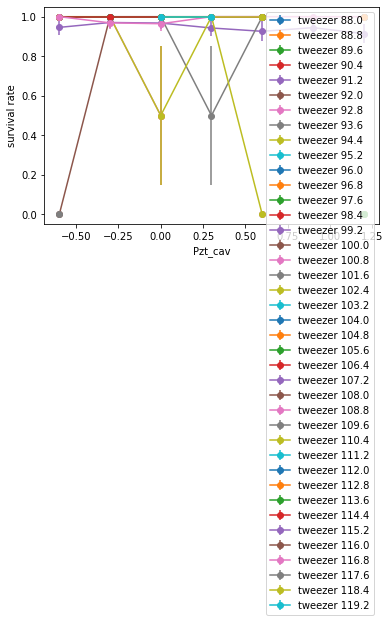

In [477]:
for tweezer in range(num_tweezers):
    plt.errorbar(point_list, point_survival[:,tweezer], point_survival_err[:,tweezer], label=f'tweezer {tweezer_freq_list[tweezer]}',
                marker='o')


plt.xlabel(point_name_inner)
plt.ylabel('survival rate')
plt.legend()

Text(0, 0.5, 'avg survival rate')

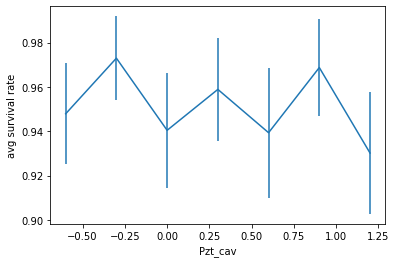

In [478]:
plt.errorbar(point_list, point_survival_1, point_survival_1_err)
plt.xlabel(point_name_inner)
plt.ylabel(f'avg survival rate')

survival rates: [       nan        nan 0.                nan        nan        nan
        nan 1.         0.5        1.                nan 0.5
 0.75       1.         0.94468085 0.875      0.5        0.57142857
 0.75       1.         1.         1.         1.         1.
 1.         1.         0.99009901 1.         1.         1.
 1.         1.                nan        nan        nan        nan
 1.                nan 1.                nan]
survival error: [       nan        nan 0.                nan        nan        nan
        nan 0.         0.35355339 0.                nan 0.35355339
 0.21650635 0.         0.01491236 0.11692679 0.25       0.18704391
 0.15309311 0.         0.         0.         0.         0.
 0.         0.         0.00696631 0.         0.         0.
 0.         0.                nan        nan        nan        nan
 0.                nan 0.                nan]


c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Event Probability')

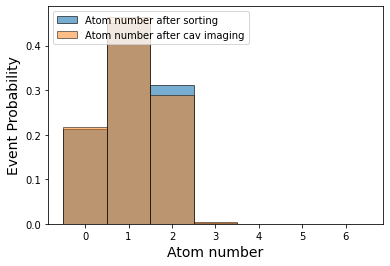

In [479]:
survival = np.zeros(num_tweezers)
survival[:]=np.nan
survival_err = np.zeros(num_tweezers)
survival_err[:]=np.nan

brightness = np.zeros(num_tweezers)
brightness[:]=np.nan
brightness_err = np.zeros(num_tweezers)
brightness_err[:]=np.nan




# atom_brightness_array = np.zeros((num_shots_sliced, num_frames, num_tweezers))
# for tweezer_counter,tweezer in enumerate(tweezer_freq_list):
#     for j in range(num_frames-1):
#         atom_brightness_array[:,j,tweezer_counter] = counts_array[num_start:num_end,j,tweezer_counter] - np.mean(counts_array[num_start:num_end,-1,tweezer_counter])



for tweezer_counter, tweezer in enumerate(tweezer_freq_list):
    mask_temp = np.logical_and((atom_existence_array[:, 0, tweezer_counter] == 1),(atom_existence_array[:, 1, tweezer_counter] == 1))
    survival[tweezer_counter] = np.count_nonzero(mask_temp)
    survival[tweezer_counter] = survival[tweezer_counter]/np.sum(atom_existence_array[:,0,tweezer_counter])
    survival_err[tweezer_counter] = np.sqrt(survival[tweezer_counter]*(1-survival[tweezer_counter])/np.sum(atom_existence_array[:,0,tweezer_counter]))
    
    
    brightness[tweezer_counter] = np.nanmean(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    brightness_err[tweezer_counter] = np.nanstd(atom_brightness_array[:,0,tweezer_counter][mask_temp])
    
            
            
print(f'survival rates: {survival}')
print(f'survival error: {survival_err}')

# atom number
atom_number=np.sum(atom_existence_array[:,:,:],axis=2)


hist_atom_edge=np.arange(-0.5,6.5+1)
hist_atom_x=(hist_atom_edge[:-1]+hist_atom_edge[1:])/2

hist_atom_0= np.histogram(atom_number[:,0],bins=hist_atom_edge)[0] 
P_atom_0=hist_atom_0/len(atom_number[:,0])

hist_atom_1= np.histogram(atom_number[:,1],bins=hist_atom_edge)[0] 
P_atom_1=hist_atom_1/len(atom_number[:,1])

plt.bar(hist_atom_x,P_atom_0,1, edgecolor="black",facecolor='C0',alpha=0.6,label='Atom number after sorting')
plt.bar(hist_atom_x,P_atom_1,1, edgecolor="black",facecolor='C1',alpha=0.5,label='Atom number after cav imaging')
plt.legend(fontsize=10,loc=2)
plt.xlabel('Atom number', fontsize=14)
plt.ylabel('Event Probability', fontsize=14)


Twz0 Loading rate 0.00, survival rate nan, brightness nan
Twz1 Loading rate 0.00, survival rate nan, brightness nan
Twz2 Loading rate 0.00, survival rate 0.00, brightness nan
Twz3 Loading rate 0.00, survival rate nan, brightness nan
Twz4 Loading rate 0.00, survival rate nan, brightness nan
Twz5 Loading rate 0.00, survival rate nan, brightness nan
Twz6 Loading rate 0.00, survival rate nan, brightness nan
Twz7 Loading rate 0.00, survival rate 1.00, brightness 601.00
Twz8 Loading rate 0.01, survival rate 0.50, brightness 991.00
Twz9 Loading rate 0.00, survival rate 1.00, brightness 1097.00
Twz10 Loading rate 0.00, survival rate nan, brightness nan
Twz11 Loading rate 0.01, survival rate 0.50, brightness 757.00
Twz12 Loading rate 0.01, survival rate 0.75, brightness 1033.33
Twz13 Loading rate 0.02, survival rate 1.00, brightness 952.86
Twz14 Loading rate 0.59, survival rate 0.94, brightness 1020.46
Twz15 Loading rate 0.02, survival rate 0.88, brightness 990.43
Twz16 Loading rate 0.01, survi

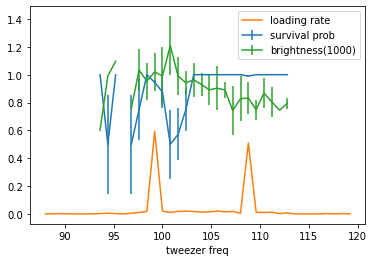

In [480]:
mask_atom_mat = atom_existence_array[:, 0,:]>0.1
mask_atom_survive_mat=np.abs(atom_existence_array[:, 0,:]-1)<0.1

loadingrate_mat=np.sum(mask_atom_mat,axis=0)/mask_atom_mat.shape[0]
for i in range(mask_atom_mat.shape[1]):
    print('''Twz{:.0f} Loading rate {:.2f}, survival rate {:.2f}, brightness {:.2f}'''.format(i,loadingrate_mat[i],survival[i],brightness[i]))
    
# print(f'average survival rate = {np.mean(survival)}')

plt.errorbar(tweezer_freq_list,survival, survival_err, label='survival prob')
plt.plot(tweezer_freq_list, loadingrate_mat, label='loading rate')
plt.errorbar(tweezer_freq_list, brightness/1000,brightness_err/1000, label='brightness(1000)')
plt.xlabel('tweezer freq')
plt.legend()

avg_survival = np.sum(atom_existence_array[:,1,:])/np.sum(atom_existence_array[:,0,:])
avg_survival_err = np.sqrt(avg_survival*(1-avg_survival)/np.sum(atom_existence_array[:,0,:]))
print(f'avg survival rate = {avg_survival} +/- {avg_survival_err}')
mean_brightness = np.sum(survival*loadingrate_mat*brightness)/np.sum(survival*loadingrate_mat)
print(f'average brightness = {mean_brightness}')
print(f'brightness per tweezer: {brightness}')
print(f'Survival rate per tweezer: {survival}')

### photon count

In [481]:
def software_gate(time_list,t_pre,N,t_probe,t_cycle):
    mask = np.full(len(time_list),False)
    for i in range(N):
        mask = mask | ((time_list>= t_pre+i*t_cycle) & (time_list<= t_pre+i*t_cycle+t_probe))
    return mask

N_cycle=20
t_probe=0.5e3
t_cycle=3.22e3

In [482]:
cavity_photoncount_array=np.zeros((num_shots_sliced,num_frames_cav))

for sliced_i,i in enumerate(range(num_start, num_end)):
    timestamp_temp=PT_cavity_timestamp_array_raw[i]
    for j in range(num_frames_cav):
        mask_temp=(PT_cavity_timestamp_array_raw[i]>=t_cav_start[j] ) & ( PT_cavity_timestamp_array_raw[i]<t_cav_end[j])
        cavity_photoncount_array[sliced_i,j]=np.sum(software_gate(PT_cavity_timestamp_array_raw[i][mask_temp],t_cav_start[j],N_cycle,t_probe,t_cycle))
        
cavity_photoncount_array_post_selected = np.zeros((num_shots_sliced,num_frames_cav))
cavity_photoncount_array_post_selected[:] = np.nan
for k in range(tweezer_num):
    for i in range(num_shots_sliced):
        for j in range(num_frames_cav_per_twz-1):
            if cavity_photoncount_array [i, num_frames_cav_per_twz*k + (j+1)] > cav_dark_threshold:
                cavity_photoncount_array_post_selected[i, num_frames_cav_per_twz*k + j] = cavity_photoncount_array[i, num_frames_cav_per_twz*k + j]
            

if post_select_true:
    cavity_photoncount_array_plot = cavity_photoncount_array_post_selected
else: 
    cavity_photoncount_array_plot = cavity_photoncount_array

c:\Users\CavityQED\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


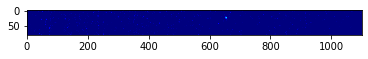

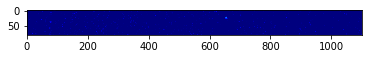

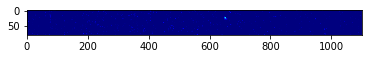

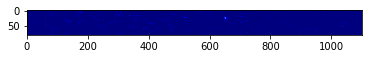

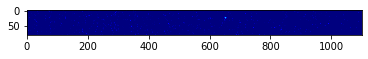

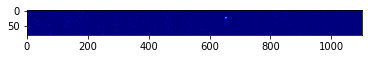

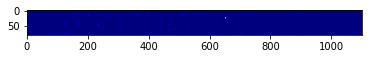

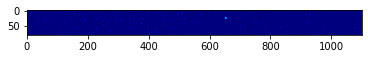

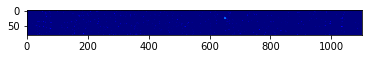

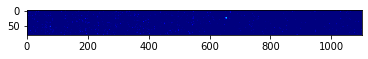

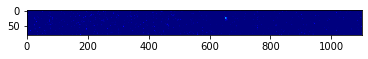

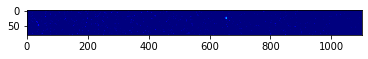

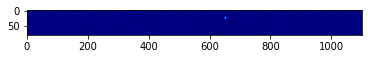

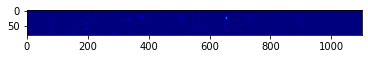

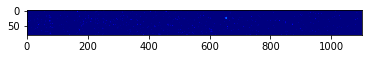

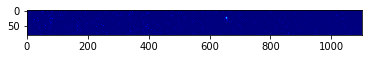

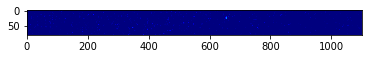

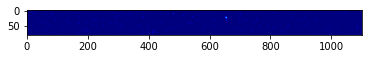

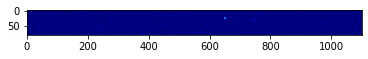

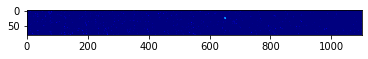

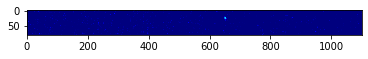

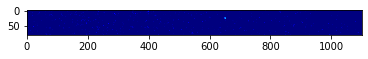

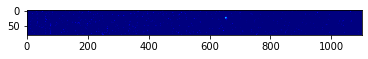

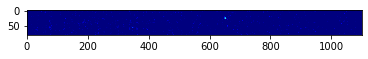

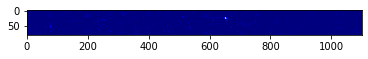

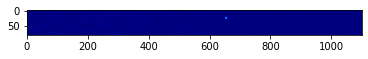

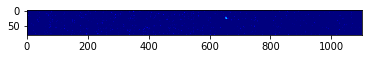

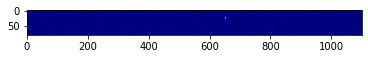

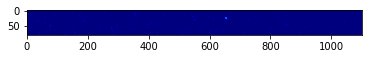

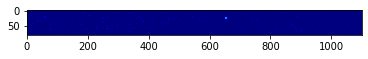

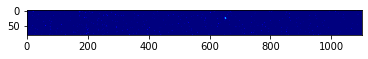

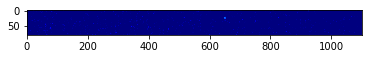

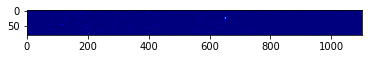

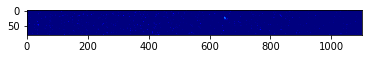

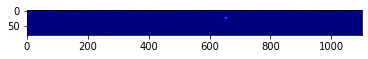

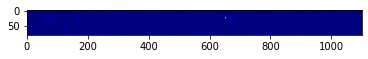

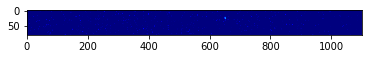

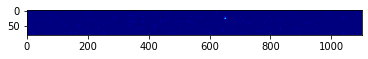

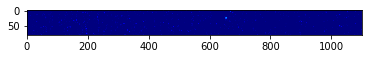

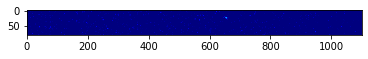

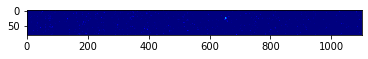

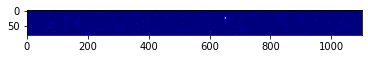

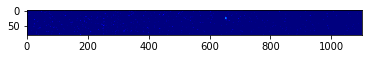

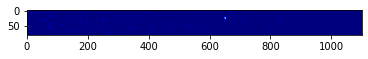

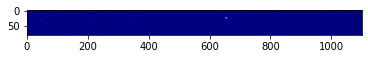

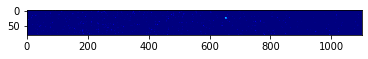

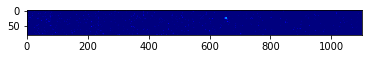

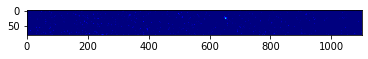

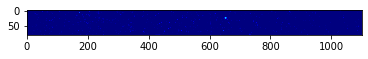

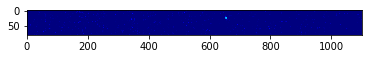

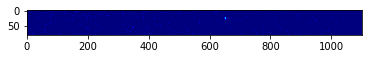

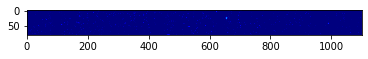

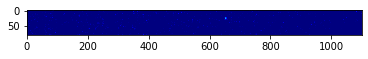

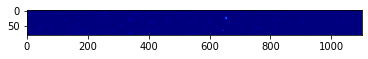

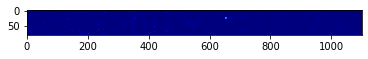

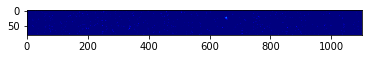

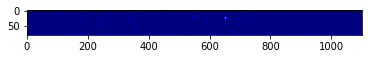

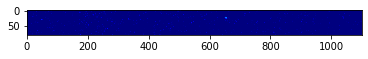

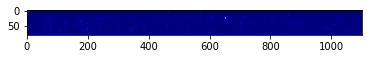

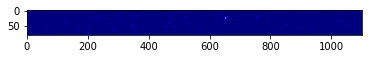

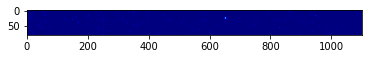

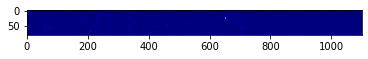

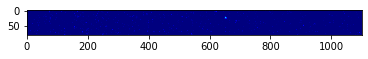

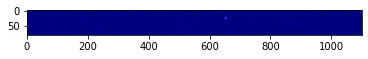

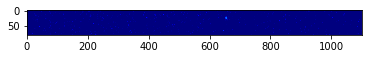

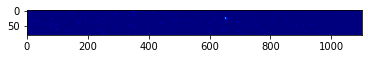

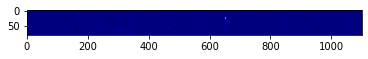

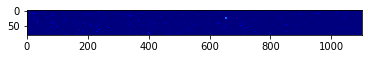

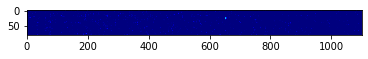

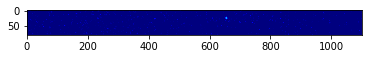

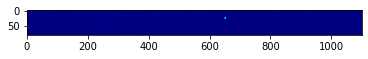

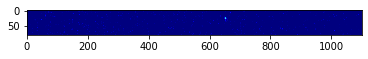

<Figure size 432x288 with 0 Axes>

In [483]:
for shot_num in range(num_shot_start, num_shot_start+num_shots):
    if mask01[shot_num,0]:
        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        hf = h5py.File(data_path/file_name, 'r')
        point = shot_num % num_points
        
        photo = np.array(hf.get('frame-'+str(2).zfill(2)))
        plt.imshow(photo, vmin=105, vmax=155, cmap='jet')
        plt.figure()
        hf.close

In [484]:
mask_edge_atoms = np.empty((num_shots_sliced, num_frames))
mask_edge_atoms[:] = np.NaN  

for frame_num in range(num_frames):             
    mask_edge_atoms[:,frame_num]=(atom_brightness_array[:,frame_num,atom_site[frame_num][0]] >= upper_threshold_mat[frame_num][0]) & (atom_brightness_array[:,frame_num,atom_site[frame_num][-1]] >= upper_threshold_mat[frame_num][-1])

mask_edge_atoms = mask11    
Image_edge_avg=0
len_edge=0
for shot_num in range(num_shot_start, num_shot_start+num_shots):
#     if quiet == False and shot_num%1000 == 0: 
#         print(f'shot_num={shot_num}')
    if mask_edge_atoms[shot_num,0]:
        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        hf = h5py.File(data_path/file_name, 'r')
        point = shot_num % num_points
        
        photo = np.array(hf.get('frame-'+str(2).zfill(2)))
        Image_edge_avg=Image_edge_avg+photo
#         plt.imshow(photo)
        len_edge=len_edge+1
        hf.close
#         plt.imshow()

if len_edge > 0:
    Image_edge_avg=Image_edge_avg/len_edge
    

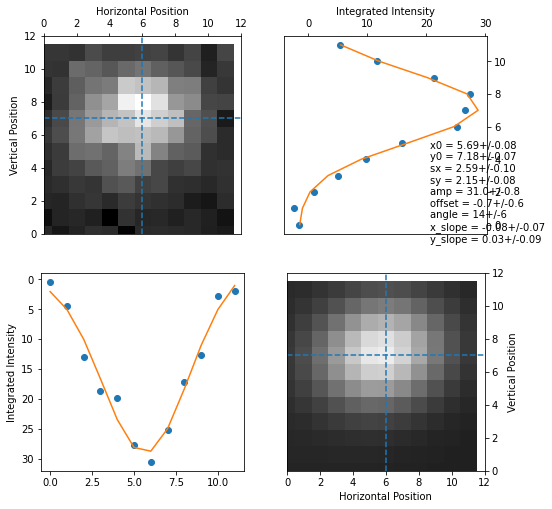

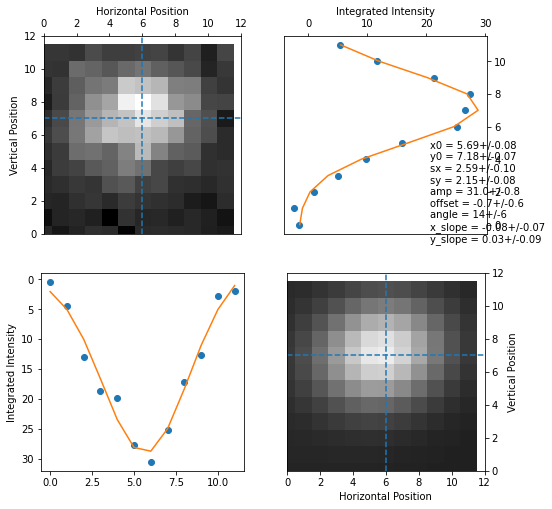

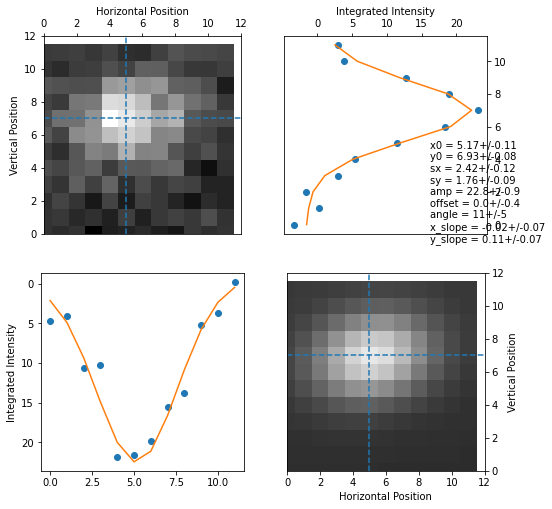

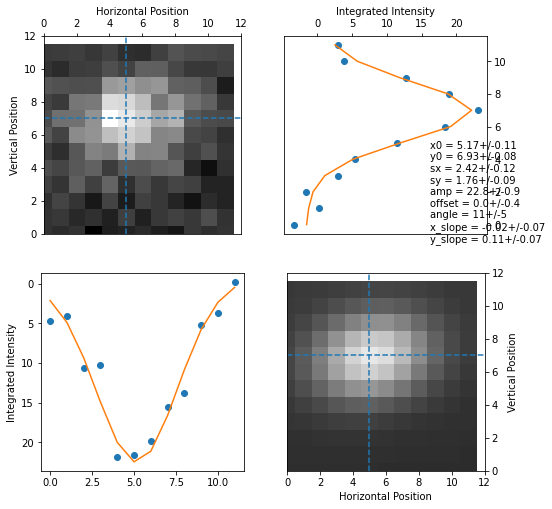

In [485]:
x_list = np.zeros(2)
x_list[:] = np.NaN
y_list = np.zeros(2)
y_list[:] = np.NaN
edge_tweezers = np.array([tweezer_freq_list[tweezer_indices[0]], tweezer_freq_list[tweezer_indices[-1]]])

for i, tweezer in enumerate(edge_tweezers):
    y_list[i] = smart_gaussian2d_fit.fit_gaussian2d(Image_edge_avg[roi_slice_func(tweezer)]-104)['y0']['val'] + roi_slice_func(tweezer)[0].start
    x_list[i] = smart_gaussian2d_fit.fit_gaussian2d(Image_edge_avg[roi_slice_func(tweezer)]-104)['x0']['val']+ roi_slice_func(tweezer)[1].start

tweezer angle = -0.9503878418922284 degrees


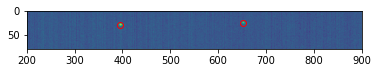

In [486]:
plt.imshow(Image_edge_avg)
plt.plot(x_list,y_list, "o", color='red',mfc='None')
# plt.axhline(y_list[0])
plt.xlim(200,900)

# plt.ylim(135,150)
# plt.ylim(120,200)

tweezer_angle = np.arctan((y_list[1]-y_list[0])/(x_list[1]-x_list[0]))
print(f'tweezer angle = {tweezer_angle*180/np.pi} degrees')

In [487]:
# make the plot

plot=False
if plot:
    C_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bins=50
    for i in range(num_tweezers):
        fig,axs=plt.subplots(ncols=num_frames+1,nrows=1,figsize=[15,6])
        
        fig.suptitle(f'Tweezer #{i}',fontsize=18)
        
        plt.sca(axs[0])
        plt.ylabel('Events #',fontsize=12)
        
        for j in range(num_frames-1):
            
            plt.sca(axs[j])
            plt.title('Frame {:.0f} Twz Freq = {:.1f}'.format(j,tweezer_freq_list[atom_site[j][i]]),fontsize=15)
            plt.hist(atom_brightness_array[:,j,atom_site[j][i]], alpha=0.75, color=C_cycle[j], bins=bins)
            plt.xlabel('Signal',fontsize=12)
            plt.axvline(upper_threshold_mat[j][i],linestyle='--',color='k')
            
        plt.sca(axs[-2])
        
        for j in range(num_frames-1):
            plt.plot(range(atom_brightness_array.shape[0]) , atom_brightness_array[:,j,atom_site[j][i]], marker='.',linestyle='None' ,
                    color=C_cycle[j],alpha=0.8)
            plt.axhline(upper_threshold_mat[j][i],linestyle='--',color=C_cycle[j])
        
        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('camera Signal',fontsize=12)
        

        
        plt.sca(axs[-1])
        
        for j in range(num_frames_cav):
            plt.plot(range(cavity_photoncount_array.shape[0]) , cavity_photoncount_array[:,j], marker='.',linestyle='None' ,
                    color=C_cycle[j],alpha=0.8)
        
        plt.xlabel('Shot #',fontsize=12)
        plt.ylabel('spcm Signal',fontsize=12)
        
        plt.tight_layout()
        plt.show()

### Atom existence and survival

In [488]:
x_val=point_list[E6math.get_point(np.arange(num_start,num_end),num_points)]
mask_xval=[np.abs(x_val-n)<0.001 for i,n in enumerate(point_list)]


In [489]:
mask_ps=mask_valid_data

In [490]:
# a list of mask for atom arrays with 1-N atoms
mask_atoms_list = []
for i in range(num_tweezers):
    mask_atoms_list.append(mask_num_atoms_list[i][:,0] > 0)
    

# a list of mask for atom arrays with all atoms
mask_if_full = np.empty((num_shots_sliced, num_frames),dtype=bool)
mask_if_full[:]=True

for i in range(mask_if_full.shape[0]):
    for j in range(num_frames):
        mask_if_full[i,j]=all(atom_existence_array[i,j,:])

# mask_full_0=mask_if_full[:,0]&mask_if_full[:,1]
mask_full_0=mask_if_full[:,0]
mask_full_1=mask_if_full[:,1]

mask_full_survive=mask_if_full[:,0] & mask_if_full[:,1] & mask_ps
mask_full_lost= mask_if_full[:,0] & (~mask_if_full[:,1])

In [520]:
bad_shot_list=[]
for i in range(num_shots_sliced):
    if cavity_photoncount_array[i]==0:
        bad_shot_list.append(i)
print(bad_shot_list)

[8, 11, 12, 13, 17, 63, 72, 118, 127, 173, 182, 191, 228, 237, 255, 283, 292, 301, 310, 347, 356]


In [521]:
x_val=point_list[E6math.get_point(np.arange(num_start,num_shots_sliced),num_points)]
mask_xval=[np.abs(x_val-n)<0.001 for i,n in enumerate(point_list)]
ind_list=np.arange(len(x_val))

mask_shot_temp=(ind_list>=0)
for i in bad_shot_list:
    mask_shot_temp=mask_shot_temp & (ind_list != i)

mask_select_shots=((ind_list>250) & mask_shot_temp)

mask_atom_00=mask00[:,0]>0
mask_atom_01=mask01[:,0]>0
mask_atom_10=mask10[:,0]>0
mask_atom_11=mask11[:,0]>0

mask_atom_0=mask_atom_10 | mask_atom_11
mask_atom_1=mask_atom_01 | mask_atom_11

mask_atom_00_survive=(mask00[:,0]>0) & (mask00[:,1]>0) & mask_ps & mask_select_shots
mask_atom_01_survive=(mask01[:,0]>0) & (mask01[:,1]>0) & mask_ps & mask_select_shots
mask_atom_10_survive=(mask10[:,0]>0) & (mask10[:,1]>0) & mask_ps & mask_select_shots
mask_atom_11_survive=(mask11[:,0]>0) & (mask11[:,1]>0) & mask_ps & mask_select_shots

# mask_atom_00_survive=(mask00[:,0]>0) 
# mask_atom_01_survive=(mask01[:,0]>0) 
# mask_atom_10_survive=(mask10[:,0]>0) 
# mask_atom_11_survive=(mask11[:,0]>0) 

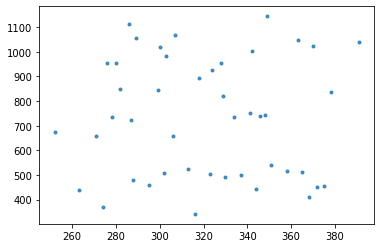

In [522]:
plt.plot(np.arange(cavity_photoncount_array.shape[0])[mask_atom_11_survive] , cavity_photoncount_array[mask_atom_11_survive], marker='.',linestyle='None' ,alpha=0.8)

In [523]:
mask_atom_11_survive[150:175]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

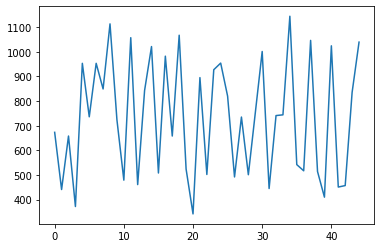

In [524]:
plt.plot(cavity_photoncount_array[mask_atom_11_survive])

# Cavity timetrace plot

Pzt_cav -0.6
273
322
336
343
357
364
Pzt_cav -0.3
267
Pzt_cav 0.0
261
338
359
373
394
Pzt_cav 0.29999999999999993
262
269
290
332
367
374
381
388
395
Pzt_cav 0.6
270
284
291
333
340
Pzt_cav 0.9
264
285
355
369
383
Pzt_cav 1.2
272
377


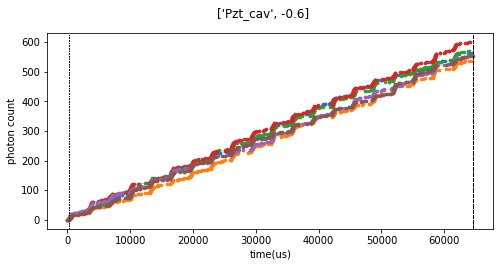

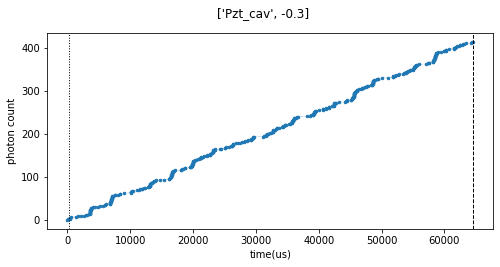

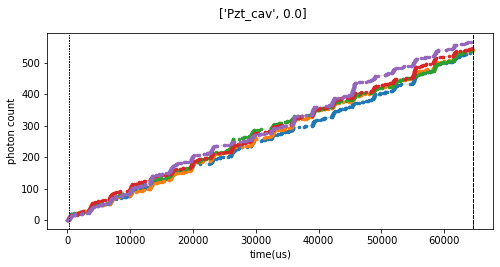

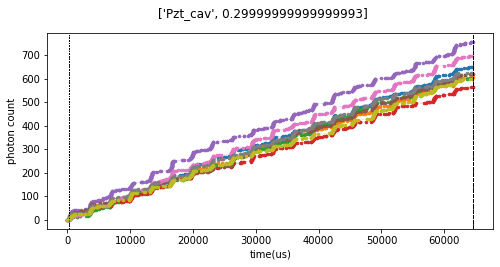

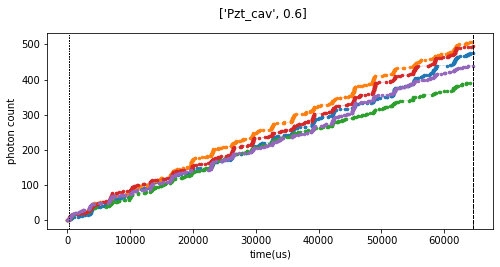

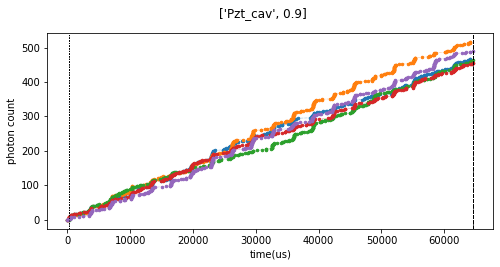

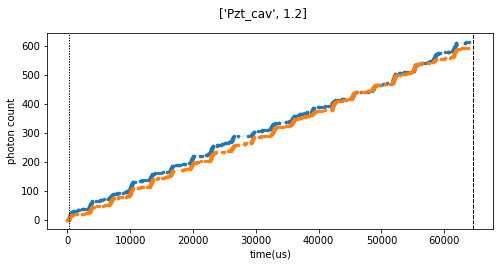

In [525]:
plot_true = True
# if plot_true:
for x_val_plot in point_list:
#     x_val_plot = 1
    ind_x=np.argmin(np.abs(point_list_inner-x_val_plot))
    print(point_name_inner, point_list_inner[ind_x])

    fig,axs=plt.subplots(ncols=1,nrows=1,figsize=[8,3.6])
    plt.suptitle([point_name_inner, point_list_inner[ind_x]])
#     plt.sca(axs[0])

    for i in range(num_shots_sliced):
#     for i in np.arange(100,200):
        if mask_xval[ind_x][i] & mask_atom_10_survive[i]: #
            print(i)
            plt.plot(PT_cavity_timestamp_array_raw[i],np.arange(len(PT_cavity_timestamp_array_raw[i])),'.:',markersize=5,linewidth=0.5)
            plt.xlabel('time(us)')
            plt.ylabel('photon count')
            for cav_frame in range(num_frames_cav_per_twz):
                plt.axvline(t_cav_start[cav_frame],c='k',linestyle=':',linewidth=1)
                plt.axvline(t_cav_end[cav_frame], c='k',linestyle='--',linewidth=1)
#                 plt.axvline(t_pre+1*t_probe + 0*t_mol)
#                 plt.axvline(t_pre+2*t_probe + 1*t_mol)


#     plt.xlim([0,700])
#     plt.ylim([0,100])
#     plt.xlim([0,74e3])
    
#     plt.ylim([-20,10000])
#     plt.ylim([-1,3])

#     plt.sca(axs[1])
#     gap_list_all = np.array([])
#     for i in range(num_shots_sliced):
#         if mask_xval[ind_x][i] & mask_full_0[i]:
#             gap_list_all = np.concatenate((gap_list_all, np.diff(PT_cavity_timestamp_array_raw[i])))
                
#     max_gap = max(gap_list_all)
#     hist_edge=np.arange(-0.5,max_gap+10,5)
#     hist_x=(hist_edge[:-1]+hist_edge[1:])/2
#     hist_y = np.histogram(gap_list_all,bins=hist_edge)[0] 
#     plt.bar(hist_x,hist_y,1, edgecolor="r",facecolor='r',alpha=0.6)
#     plt.yscale('log')

#     plt.xlim([t_cav_start[num_frames_cav_per_twz]-20,t_cav_end[2*num_frames_cav_per_twz-1]+10]);
#     plt.ylim([-20,100])

In [526]:
# PT_cavity_timestamp_array_new = []

# for shot_num in range(num_shots_sliced):
#     PT_cavity_timestamp_array_cycles = []
#     for i in range(num_cycles):
#         timestamp_list = []
#         for j in range(len(PT_cavity_timestamp_array_raw[shot_num])):   
#             if t_pre + (t_probe + t_mol)*i < PT_cavity_timestamp_array_raw[shot_num][j] <= t_pre + t_probe*(i+1) + t_mol*i:
#                 timestamp_list.append(PT_cavity_timestamp_array_raw[shot_num][j])
#         PT_cavity_timestamp_array_cycles.append(timestamp_list)
# #     PT_cavity_timestamp_array_cycles = np.array(PT_cavity_timestamp_array_cycles)
#     PT_cavity_timestamp_array_new.append(PT_cavity_timestamp_array_cycles)
# PT_cavity_timestamp_array_new = np.array(PT_cavity_timestamp_array_new)

In [527]:
# ind_shot=20

# plt.plot(PT_cavity_timestamp_array_new[ind_shot][4], np.arange(len(PT_cavity_timestamp_array_new[ind_shot][4])))

In [528]:
# def quadratic_fit(t, a, b):
#     return a*t + b*t**2

In [529]:
# b_list = np.empty((num_shots_sliced, num_cycles))
# b_list[:] = np.NaN

# a_list = np.empty((num_shots_sliced, num_cycles))
# a_list[:] = np.NaN

# for shot_num in range(num_shots_sliced):
#     for i in range(num_cycles):
#         if mask_full_0[shot_num]:
#             data = PT_cavity_timestamp_array_new[shot_num][i] - PT_cavity_timestamp_array_new[shot_num][i][0]
#             if len(data) >= 2:
#                 popt = curve_fit(quadratic_fit, data, np.arange(len(data)), p0 = [0,-1e-4])[0]
#                 b_list[shot_num][i] = popt[1]
#                 a_list[shot_num][i] = popt[0]

In [530]:
# b_point_list = []
# for point in range(num_points):
#     b_point_list.append(b_list[point::num_points])

# b_point_list = np.array(b_point_list)

In [531]:
# shot = 35
# cycle = 2

# plt.plot(PT_cavity_timestamp_array_new[shot][cycle]-PT_cavity_timestamp_array_new[shot][cycle][0], np.arange(len(PT_cavity_timestamp_array_new[shot][cycle])))
# plt.plot(np.arange(t_probe), quadratic_fit(np.arange(t_probe), a_list[shot][cycle], b_list[shot][cycle]))

In [532]:
# b_point_avg_list = []
# for point in range(num_points):
#     b_point_avg_list.append(np.nanmean(b_point_list[point]))

In [533]:
# plt.plot(b_point_avg_list)

In [534]:
# hist_b_point_list = []
# for point in range(num_points):
#     plt.figure()
#     b_point_list_1 = b_point_list[point].flatten()[~np.isnan(b_point_list[point].flatten())]
#     hist_b_point_list.append(b_point_list_1)
#     plt.hist(b_point_list_1, density=False, bins=20, label=f'{point_name_inner} = {point_list[point]}')
#     plt.axvline(0,linestyle='--',color='k')
#     plt.legend()

## Make plots for a certain atom/tweezer

In [535]:
mask_select=mask_full_survive.copy()

In [536]:
# Bin data
x_bin_all_list=[[]]*num_frames_cav
photoncount_bin_all_list=[[]]*num_frames_cav
photoncount_bin_all_err_list=[[]]*num_frames_cav
photoncount_bin_all_mean_err_list=[[]]*num_frames_cav

x_bin_num_atoms_list = []
photoncount_bin_num_atoms_list = []
photoncount_bin_num_atoms_err_list = []
photoncount_bin_num_atoms_mean_err_list = []
for n in range(num_tweezers):
    x_bin_num_atoms_list.append([[]]*num_frames_cav)
    photoncount_bin_num_atoms_list.append([[]]*num_frames_cav)
    photoncount_bin_num_atoms_err_list.append([[]]*num_frames_cav)
    photoncount_bin_num_atoms_mean_err_list.append([[]]*num_frames_cav)

# TO DO: update the binning method to bin on x_val_corrected instead of x_val, actually maybe do both.
for cav_frame in range(num_frames_cav):
    
    x_bin,photoncount_bin_all,photoncount_bin_all_err,photoncount_bin_all_mean_err=uniquebin(x_val[mask_select],cavity_photoncount_array_plot[mask_select,cav_frame])
    x_bin_all_list[cav_frame]=x_bin
    photoncount_bin_all_list[cav_frame]=photoncount_bin_all
    photoncount_bin_all_err_list[cav_frame]=photoncount_bin_all_err
    photoncount_bin_all_mean_err_list[cav_frame]=photoncount_bin_all_mean_err
    
    for n in range(num_tweezers):
        x_bin,photoncount_bin_num_atoms,photoncount_bin_num_atoms_err,photoncount_bin_num_atoms_mean_err = uniquebin(x_val[mask_atoms_list[n]],cavity_photoncount_array_plot[mask_atoms_list[n],cav_frame])
        x_bin_num_atoms_list[n][cav_frame]=x_bin
        photoncount_bin_num_atoms_list[n][cav_frame] = photoncount_bin_num_atoms
        photoncount_bin_num_atoms_err_list[n][cav_frame]=photoncount_bin_num_atoms_err
        photoncount_bin_num_atoms_mean_err_list[n][cav_frame]=photoncount_bin_all_mean_err

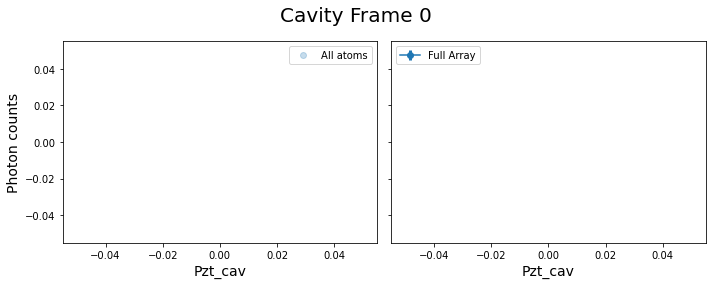

In [537]:
# show individual and binned data, plot against cicero control parameter

for cav_frame in range(num_frames_cav):
    fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[10,4],sharex=True,sharey=True)
    plt.sca(axs[0])
#     # plot data with "num_atoms" atoms
#     for num_atoms in range(num_tweezers):
#         plt.plot(x_val[mask_atoms_list[num_atoms]], cavity_photoncount_array_plot[:,cav_frame][mask_atoms_list[num_atoms]], 'o', label=f'atom num = {num_atoms+1}',alpha=0.25)
    
    # plot data with alll atoms:
    plt.plot(x_val[mask_select], cavity_photoncount_array_plot[:,cav_frame][mask_select], 'o', label=f'All atoms',alpha=0.25)
    
    
    plt.legend()
    plt.xlabel(point_name_inner,fontsize=14)
    plt.ylabel('Photon counts',fontsize=14)
#     plt.xlabel(point_name_inner,fontsize=14)
    
    plt.sca(axs[1])
#     # plot data with "num_atoms" atoms
#     for num_atoms in range(num_tweezers):
#         plt.errorbar(x_bin_num_atoms_list[num_atoms][cav_frame],photoncount_bin_num_atoms_list[num_atoms][cav_frame],yerr=photoncount_bin_num_atoms_err_list[num_atoms][cav_frame],label=f'atom num = {num_atoms+1}',marker='o',elinewidth=3,zorder=0)
    # plot data with alll atoms:
    plt.errorbar(x_bin_all_list[cav_frame],photoncount_bin_all_list[cav_frame],yerr=photoncount_bin_all_mean_err_list[cav_frame],label=f'Full Array',marker='o',elinewidth=3,zorder=0)
    
    plt.legend(loc=2)

#     plt.xlabel(r'$\Delta_{PC}$ (MHz)',fontsize=14)
    plt.xlabel(point_name_inner,fontsize=14)

    plt.suptitle('Cavity Frame {:.0f}'.format(cav_frame),fontsize=20)
    plt.tight_layout()
    plt.show()
    


In [538]:
# Bin data
x_bin00_list=[[]]*num_frames_cav
x_bin01_list=[[]]*num_frames_cav
x_bin10_list=[[]]*num_frames_cav
x_bin11_list=[[]]*num_frames_cav

photoncount_bin00_list=[[]]*num_frames_cav
photoncount_bin00_err_list=[[]]*num_frames_cav
photoncount_bin00_mean_err_list=[[]]*num_frames_cav

photoncount_bin01_list=[[]]*num_frames_cav
photoncount_bin01_err_list=[[]]*num_frames_cav
photoncount_bin01_mean_err_list=[[]]*num_frames_cav

photoncount_bin10_list=[[]]*num_frames_cav
photoncount_bin10_err_list=[[]]*num_frames_cav
photoncount_bin10_mean_err_list=[[]]*num_frames_cav

photoncount_bin11_list=[[]]*num_frames_cav
photoncount_bin11_err_list=[[]]*num_frames_cav
photoncount_bin11_mean_err_list=[[]]*num_frames_cav

# TO DO: update the binning method to bin on x_val_corrected instead of x_val, actually maybe do both.
for cav_frame in range(num_frames_cav):
    x_bin,photoncount_bin00,photoncount_bin00_err,photoncount_bin00_mean_err=uniquebin(x_val[mask_atom_00_survive],cavity_photoncount_array_plot[mask_atom_00_survive,cav_frame])
    x_bin00_list[cav_frame]=x_bin
    photoncount_bin00_list[cav_frame]=photoncount_bin00
    photoncount_bin00_err_list[cav_frame]=photoncount_bin00_err
    photoncount_bin00_mean_err_list[cav_frame]=photoncount_bin00_mean_err
    
    x_bin,photoncount_bin01,photoncount_bin01_err,photoncount_bin01_mean_err=uniquebin(x_val[mask_atom_01_survive],cavity_photoncount_array_plot[mask_atom_01_survive,cav_frame])
    x_bin01_list[cav_frame]=x_bin
    photoncount_bin01_list[cav_frame]=photoncount_bin01
    photoncount_bin01_err_list[cav_frame]=photoncount_bin01_err
    photoncount_bin01_mean_err_list[cav_frame]=photoncount_bin01_mean_err
    
    x_bin,photoncount_bin10,photoncount_bin10_err,photoncount_bin10_mean_err=uniquebin(x_val[mask_atom_10_survive],cavity_photoncount_array_plot[mask_atom_10_survive,cav_frame])
    x_bin10_list[cav_frame]=x_bin
    photoncount_bin10_list[cav_frame]=photoncount_bin10
    photoncount_bin10_err_list[cav_frame]=photoncount_bin10_err
    photoncount_bin10_mean_err_list[cav_frame]=photoncount_bin10_mean_err
    
    x_bin,photoncount_bin11,photoncount_bin11_err,photoncount_bin11_mean_err=uniquebin(x_val[mask_atom_11_survive],cavity_photoncount_array_plot[mask_atom_11_survive,cav_frame])
    x_bin11_list[cav_frame]=x_bin
    photoncount_bin11_list[cav_frame]=photoncount_bin11
    photoncount_bin11_err_list[cav_frame]=photoncount_bin11_err
    photoncount_bin11_mean_err_list[cav_frame]=photoncount_bin11_mean_err

In [539]:
# # show individual and binned data

# for cav_frame in range(num_frames_cav):
#     fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[10,4],sharex=True,sharey=True)
#     plt.sca(axs[0])
    
    
#     plt.plot(x_val[mask_atom_01_survive],cavity_photoncount_array_plot[:,cav_frame][mask_atom_01_survive],'ob',label=f'twz{tweezer_freq_list[1]}',alpha=0.25)
#     plt.plot(x_val[mask_atom_10_survive],cavity_photoncount_array_plot[:,cav_frame][mask_atom_10_survive],'or',label=f'twz{tweezer_freq_list[0]}',alpha=0.25)
#     plt.plot(x_val[mask_atom_00_survive],cavity_photoncount_array_plot[:,cav_frame][mask_atom_00_survive],'ok',mfc='None',label='no atom',alpha=0.35)
#     plt.plot(x_val[mask_atom_11_survive],cavity_photoncount_array_plot[:,cav_frame][mask_atom_11_survive],'og',label='11',alpha=0.25)
    
#     plt.legend()
#     plt.ylabel('Photon counts',fontsize=14)
# #     plt.xlabel(point_name_inner,fontsize=14)
    
#     plt.sca(axs[1])
#     plt.errorbar(x_bin00_list[cav_frame],photoncount_bin00_list[cav_frame],yerr=photoncount_bin00_err_list[cav_frame],label='no atom',marker='o',elinewidth=3,color='k',zorder=0)
#     plt.errorbar(x_bin01_list[cav_frame],photoncount_bin01_list[cav_frame],yerr=photoncount_bin01_err_list[cav_frame],label=f'twz{tweezer_freq_list[tweezer_indices[1]]}',marker='o',elinewidth=3,color='b',zorder=0)
#     plt.errorbar(x_bin10_list[cav_frame],photoncount_bin10_list[cav_frame],yerr=photoncount_bin10_err_list[cav_frame],label=f'twz{tweezer_freq_list[tweezer_indices[0]]}',marker='o',elinewidth=3,color='r',zorder=0)
# #     
# #     plt.errorbar(x_bin10_list[cav_frame],photoncount_bin10_list[cav_frame]+photoncount_bin01_list[cav_frame],yerr=np.sqrt(photoncount_bin10_err_list[cav_frame]**2+photoncount_bin01_err_list[cav_frame]**2),label='10+01',marker='o',elinewidth=3,color='C4',zorder=0)
    
    
#     plt.errorbar(x_bin11_list[cav_frame],photoncount_bin11_list[cav_frame],yerr=photoncount_bin11_err_list[cav_frame],label='11',marker='o',elinewidth=3,color='g',zorder=0)
    
#     plt.legend(loc=2)

# #     plt.xlabel(r'$\Delta_{PC}$ (MHz)',fontsize=14)
#     plt.xlabel(point_name_inner,fontsize=14)

#     plt.suptitle('Cavity Frame {:.0f}'.format(cav_frame),fontsize=20)
#     plt.tight_layout()
#     plt.show()
    


Text(0.5, 0, 'Pzt_cav')

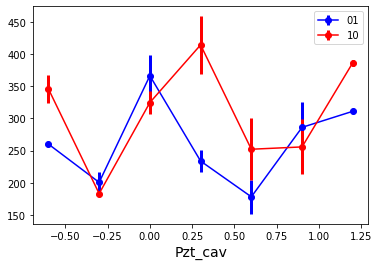

In [540]:
BG_signal=30#np.mean(photoncount_bin00_list[0])


plt.errorbar(x_bin01_list[cav_frame],photoncount_bin01_list[cav_frame]-BG_signal,yerr=photoncount_bin01_err_list[cav_frame],label='01',marker='o',elinewidth=3,color='b',zorder=0)
plt.errorbar(x_bin10_list[cav_frame],photoncount_bin10_list[cav_frame]-BG_signal,yerr=photoncount_bin10_err_list[cav_frame],label='10',marker='o',elinewidth=3,color='r',zorder=0)
plt.legend()
plt.xlabel(point_name_inner,fontsize=14)

In [541]:
BG_signal

30

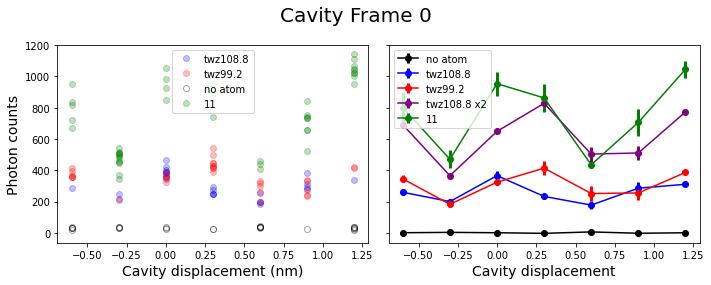

In [542]:
# show individual and binned data

# conversion = 250
conversion = 1


for cav_frame in range(num_frames_cav):
    fig,axs=plt.subplots(ncols=2,nrows=1,figsize=[10,4],sharex=True,sharey=True)
    plt.sca(axs[0])
    
    
    plt.plot(x_val[mask_atom_01_survive]*conversion,cavity_photoncount_array_plot[:,cav_frame][mask_atom_01_survive],'ob',label=f'twz{tweezer_freq_list[tweezer_indices[1]]}',alpha=0.25)
    plt.plot(x_val[mask_atom_10_survive]*conversion,cavity_photoncount_array_plot[:,cav_frame][mask_atom_10_survive],'or',label=f'twz{tweezer_freq_list[tweezer_indices[0]]}',alpha=0.25)
    plt.plot(x_val[mask_atom_00_survive]*conversion,cavity_photoncount_array_plot[:,cav_frame][mask_atom_00_survive],'ok',mfc='None',label='no atom',alpha=0.35)
    plt.plot(x_val[mask_atom_11_survive]*conversion,cavity_photoncount_array_plot[:,cav_frame][mask_atom_11_survive],'og',label='11',alpha=0.25)
    
    plt.legend()
    plt.ylabel('Photon counts',fontsize=14)
    plt.xlabel('Cavity displacement (nm)',fontsize=14)
    
    plt.sca(axs[1])
    plt.errorbar(x_bin00_list[cav_frame]*conversion,photoncount_bin00_list[cav_frame]-BG_signal,yerr=photoncount_bin00_err_list[cav_frame],label='no atom',marker='o',elinewidth=3,color='k',zorder=0)
    plt.errorbar(x_bin01_list[cav_frame]*conversion,photoncount_bin01_list[cav_frame]-BG_signal,yerr=photoncount_bin01_err_list[cav_frame],label=f'twz{tweezer_freq_list[tweezer_indices[1]]}',marker='o',elinewidth=3,color='b',zorder=0)
    plt.errorbar(x_bin10_list[cav_frame]*conversion,photoncount_bin10_list[cav_frame]-BG_signal,yerr=photoncount_bin10_err_list[cav_frame],label=f'twz{tweezer_freq_list[tweezer_indices[0]]}',marker='o',elinewidth=3,color='r',zorder=0)
    plt.errorbar(x_bin10_list[cav_frame]*conversion,2*photoncount_bin10_list[cav_frame]-2*BG_signal,yerr=photoncount_bin10_err_list[cav_frame],label=f'twz{tweezer_freq_list[tweezer_indices[1]]} x2',marker='o',elinewidth=3,color='purple',zorder=0)

    # plt.errorbar(x_bin10_list[cav_frame],photoncount_bin10_list[cav_frame]+photoncount_bin01_list[cav_frame]-2*BG_signal,yerr=np.sqrt(photoncount_bin10_err_list[cav_frame]**2+photoncount_bin01_err_list[cav_frame]**2),label='10+01',marker='o',elinewidth=3,color='C4',zorder=0)
    # 
    
    plt.errorbar(x_bin11_list[cav_frame]*conversion,photoncount_bin11_list[cav_frame],yerr=photoncount_bin11_err_list[cav_frame],label='11',marker='o',elinewidth=3,color='g',zorder=0)
    
    plt.legend(loc=2)

#     plt.xlabel(r'$\Delta_{PC}$ (MHz)',fontsize=14)
    plt.xlabel('Cavity displacement',fontsize=14)

    plt.suptitle('Cavity Frame {:.0f}'.format(cav_frame),fontsize=20)
    plt.tight_layout()
    plt.show()
    


In [543]:
# plt.plot(point_list, b_point_avg_list)
# plt.xlabel(point_name_inner)
# plt.ylabel('average b')

### Fit the oscillation

In [544]:
def Oscillation_fitfun(x,x0,omega,ymax,ymin):
    return (ymax-ymin)/2*np.cos((x-x0)*omega)+(ymax+ymin)/2

def Oscillation_fitfun2(x,x0,ymax,ymin):
    omega_temp=2*np.pi
    return (ymax-ymin)/2*np.cos((x-x0)*omega_temp)+(ymax+ymin)/2

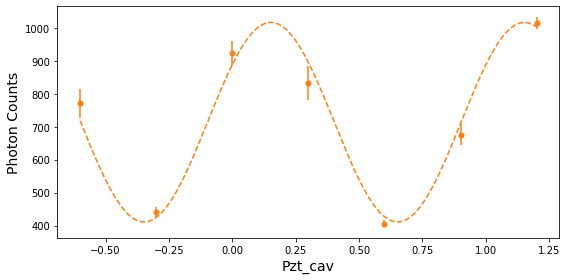

In [545]:
# BG_signal=np.mean(photoncount_bin00_list[0])

x_all= x_bin11_list[0] # x_bin_all_list[0]
y_all= photoncount_bin11_list[0]-BG_signal # photoncount_bin_all_list[0]-BG_signal
y_all_err = photoncount_bin11_mean_err_list[0] #photoncount_bin_all_mean_err_list[0]

popt_all,pcov_all=curve_fit(Oscillation_fitfun2,x_all,y_all,p0=[x_all[np.argmax(y_all)],np.max(y_all),np.min(y_all)])
popt_all_err=np.sqrt(np.diag(pcov_all))

x_1=x_bin01_list[0]
y_1=photoncount_bin01_list[0]-BG_signal
y_1_err=photoncount_bin01_err_list[0]

x_2=x_bin10_list[0]
y_2=photoncount_bin10_list[0]-BG_signal
y_2_err=photoncount_bin10_err_list[0]

# x_single=x_bin10_list[cav_frame]
# y_single=photoncount_bin10_list[cav_frame]+photoncount_bin01_list[cav_frame]-2*BG_signal
# y_single_err=np.sqrt(photoncount_bin10_err_list[cav_frame]**2+photoncount_bin01_err_list[cav_frame]**2)

# popt_single,pcov_single=curve_fit(Oscillation_fitfun2,x_single,y_single,p0=[x_single[np.argmax(y_single)],np.max(y_single),np.min(y_single)])
# popt_single_err=np.sqrt(np.diag(pcov_single))






# popt_1,pcov_1=curve_fit(Oscillation_fitfun,x_1,y_1,sigma=y_1_err,p0=[1.5,2,np.max(y_1),np.min(y_1)])
popt_1,pcov_1=curve_fit(Oscillation_fitfun2,x_1,y_1,p0=[x_1[np.argmax(y_1)],np.max(y_1),np.min(y_1)])
popt_1_err=np.sqrt(np.diag(pcov_1))
   
popt_2,pcov_2=curve_fit(Oscillation_fitfun2,x_2,y_2,p0=[x_2[np.argmax(y_2)],np.max(y_2),np.min(y_2)])
popt_2_err=np.sqrt(np.diag(pcov_2))
   

                     
xplot=np.linspace(np.min(point_list),np.max(point_list),201)

fig,axs=plt.subplots(ncols=1,nrows=1,figsize=[8,4])

plt.errorbar(x_all,y_all,yerr=y_all_err,linestyle='None',marker='o',markersize=5,color='C1')
plt.plot(xplot,Oscillation_fitfun2(xplot,*popt_all),color='C1',linestyle='--')

plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Counts',fontsize=14)

plt.tight_layout()


Phase difference in single atom signal -0.330+/-0.072*pi


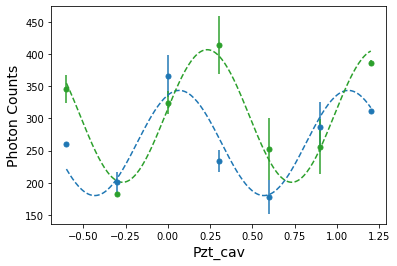

In [546]:
xplot=np.linspace(np.min(point_list),np.max(point_list),201)

omega_fix=2*np.pi

def Oscillation_fixw_fitfun(x,phi,A,offset):
    return A*np.cos(x*omega_fix+phi)+offset


popt_1_fix,pcov_1_fix=curve_fit(Oscillation_fixw_fitfun,x_1,y_1,p0=[0*np.pi,np.max(y_1)-np.min(y_1),(np.max(y_1)-np.min(y_1))/2],bounds=([-2*np.pi,0,0],[2*np.pi,np.inf,np.inf]))
# popt_1_fix,pcov_1_fix=curve_fit(Oscillation_fixw_fitfun,x_1,y_1,p0=[-np.pi,np.max(y_1)-np.min(y_1),(np.max(y_1)-np.min(y_1))/2])

popt_1_fix_err=np.sqrt(np.diag(pcov_1_fix))

popt_2_fix,pcov_2_fix=curve_fit(Oscillation_fixw_fitfun,x_2,y_2,p0=[0*np.pi,np.max(y_2)-np.min(y_2),(np.max(y_2)-np.min(y_2))/2],bounds=([-2*np.pi,0,0],[2*np.pi,np.inf,np.inf]))
# popt_2_fix,pcov_2_fix=curve_fit(Oscillation_fixw_fitfun,x_2,y_2,p0=[0,np.max(y_2)-np.min(y_2),(np.max(y_2)-np.min(y_2))/2])

popt_2_fix_err=np.sqrt(np.diag(pcov_2_fix))

plt.errorbar(x_1,y_1,yerr=y_1_err,linestyle='None',marker='o',markersize=5,color='C0',label='atom 0')
plt.plot(xplot,Oscillation_fixw_fitfun(xplot,*popt_1_fix),color='C0',linestyle='--')
plt.errorbar(x_2,y_2,yerr=y_2_err,linestyle='None',marker='o',markersize=5,color='C2',label='atom 1')
plt.plot(xplot, Oscillation_fixw_fitfun(xplot,*popt_2_fix),color='C2',linestyle='--')

plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Counts',fontsize=14)

Delta_phi=popt_2_fix[0]-popt_1_fix[0]
Delta_phi_err=np.sqrt(popt_1_fix_err[0]**2+popt_2_fix_err[0]**2)

Delta_phi_pi=Delta_phi/np.pi
Delta_phi_pi_err=Delta_phi_err/np.pi

print('Phase difference in single atom signal {:.3f}+/-{:.3f}*pi'.format(Delta_phi_pi,Delta_phi_pi_err))

Contrast of 2-atom signal: 42.4+/-2.3%
Contrast of twz108.8 signal: 31.2+/-4.2%
Contrast of twz99.2 signal: 33.9+/-2.1%
Maximum point 0.23+/-0.02 for twz99.200


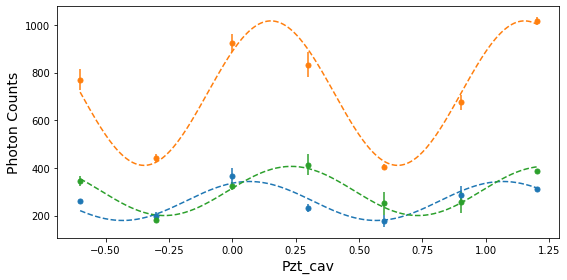

In [547]:
# conversion_all=390*popt_all[1]/(2*np.pi)
# conversion_all_err=390*popt_all_err[1]/(2*np.pi)

conversion_sys=250
conversion_sys_err=0

contrast_all=(popt_all[1]-popt_all[2])/(popt_all[1]+popt_all[2])
contrast_all_err=np.sqrt(popt_all_err[1]**2+popt_all_err[2])/(popt_all[1]+popt_all[2])

contrast_1=(popt_1[1]-popt_1[2])/(popt_1[1]+popt_1[2])
contrast_1_err=np.sqrt(popt_1_err[1]**2+popt_1_err[2])/(popt_1[1]+popt_1[2])

contrast_2=(popt_2[1]-popt_2[2])/(popt_2[1]+popt_2[2])
contrast_2_err=np.sqrt(popt_2_err[1]**2+popt_2_err[2])/(popt_2[1]+popt_2[2])


# contrast_single=(popt_single[1]-popt_single[2])/(popt_single[1]+popt_single[2])
# contrast_single_err=np.sqrt(popt_single_err[1]**2+popt_single_err[2])/(popt_single[1]+popt_single[2])


# print('Cicero control voltage to distance conversion (all atom): {:.1f}+/-{:.1f}'.format(conversion_all,conversion_all_err))
print('Contrast of 2-atom signal: {:.1f}+/-{:.1f}%'.format(contrast_all*100,contrast_all_err*100) )
print('Contrast of twz{:.1f} signal: {:.1f}+/-{:.1f}%'.format(tweezer_freq_list[tweezer_indices[1]],contrast_1*100,contrast_1_err*100) )
print('Contrast of twz{:.1f} signal: {:.1f}+/-{:.1f}%'.format(tweezer_freq_list[tweezer_indices[0]],contrast_2*100,contrast_2_err*100) )
# print('Contrast of single atom signal*2: {:.1f}+/-{:.1f}%'.format(contrast_single*100,contrast_single_err*100) )
print('Maximum point {:.2f}+/-{:.2f} for twz{:.3f}'.format(popt_2[0],popt_2_err[0],tweezer_freq_list[tweezer_indices[0]]))

fig,axs=plt.subplots(ncols=1,nrows=1,figsize=[8,4])

plt.errorbar(x_all,y_all,yerr=y_all_err,linestyle='None',marker='o',markersize=5,color='C1')
plt.plot(xplot,Oscillation_fitfun2(xplot,*popt_all),color='C1',linestyle='--')

plt.errorbar(x_1,y_1,yerr=y_1_err,linestyle='None',marker='o',markersize=5,color='C0',label='atom 0')
plt.plot(xplot,Oscillation_fitfun2(xplot,*popt_1),color='C0',linestyle='--')
plt.errorbar(x_2,y_2,yerr=y_2_err,linestyle='None',marker='o',markersize=5,color='C2',label='atom 1')
plt.plot(xplot, Oscillation_fitfun2(xplot,*popt_2),color='C2',linestyle='--')



plt.xlabel(point_name_inner,fontsize=14)
plt.ylabel('Photon Counts',fontsize=14)

plt.tight_layout()


# sup_factor=y_all/y_single
# sup_factor_err=np.sqrt((y_all_err/y_all)**2+(y_single_err/y_single)**2)*sup_factor

# fig,axs=plt.subplots(ncols=1,nrows=2,figsize=[8,8])

# plt.sca(axs[0])

# plt.errorbar(x_all*conversion_sys,y_all,yerr=y_all_err,linestyle='None',marker='o',markersize=5,color='C1',label='2 atoms')
# plt.plot(xplot*conversion_sys,Oscillation_fitfun2(xplot,*popt_all),color='C1',linestyle='--')

# plt.errorbar(x_single*conversion_sys,y_single,yerr=y_single_err,linestyle='None',marker='o',markersize=5,color='C0',label='single atom *2')
# plt.plot(xplot*conversion_sys,Oscillation_fitfun2(xplot,*popt_single),color='C0',linestyle='--')



# plt.xlabel('scan distance (nm)',fontsize=14)
# plt.ylabel('Photon Counts',fontsize=14)
# plt.legend()

# plt.sca(axs[1])

# plt.errorbar(x_all*conversion_sys,sup_factor,yerr=sup_factor_err,linestyle='None',marker='o',markersize=5,color='C2',label='2 atoms')
# plt.plot(xplot*conversion_sys,Oscillation_fitfun2(xplot,*popt_all)/Oscillation_fitfun2(xplot,*popt_single),color='C2',linestyle='--')

# plt.axhline(1.74,linestyle='--')
# plt.xlabel('scan distance (nm)',fontsize=14)
# plt.ylabel('Superradiance facotr',fontsize=14)

# plt.tight_layout()



In [548]:
num_shots

396